In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KDTree

from metrics_scripts.metrics_utils import *

import pandas as pd
from osgeo import ogr, gdal, osr

import cPickle as pickle

import itertools

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from shapely.geometry import shape, Point, Polygon, MultiLineString, MultiPoint, MultiPolygon, LineString

from sklearn.decomposition import PCA

In [2]:
islands, fields = load_shapefile('ganges_metrics/metrics_results/islands_properties.shp', parameters='all')




fields = {k:np.array(v) for k,v in fields.iteritems()}

fields['r_perim'] = fields['p_wetperim'] / fields['p_perim']

# del fields['p_num_ox']


classify_data_raw = pd.DataFrame()



# for k in fields.keys():

#     classify_data2[k.encode('utf-8')] = np.log10(fields[k] /
#                                      fields[k].min())
    
#     if classify_data2[k].min() == np.inf:
        
#         vals = np.log10(fields[k] + 0.1)
#         vals[vals == -1] = 0
        
#         classify_data2[k.encode('utf-8')] = vals
            
    
# min_max_scaler = MinMaxScaler()
# scaled_data = min_max_scaler.fit_transform(classify_data2.values)

# for n,c in enumerate(classify_data2.columns):
#     classify_data2[c] = scaled_data[:,n]

# pd.to_pickle(classify_data2, 'ganges_metrics/metrics_results/classify_data2')

In [3]:
classify_data_raw = pd.DataFrame()



for k in fields.keys():

    classify_data_raw[k.encode('utf-8')] = (fields[k] - fields[k].min()) / (fields[k].max() - fields[k].min())
    
    if classify_data_raw[k].min() == np.inf:
        
        vals = np.log10(fields[k] + 0.1)
        vals[vals == -1] = 0
        
        classify_data_raw[k.encode('utf-8')] = vals

In [4]:
# zones = classify_data2['zone']

zones = classify_data_raw['zone']
classify_data_raw.drop('zone', axis = 1, inplace = True)
classify_data_raw.drop('p_int_len', axis = 1, inplace = True)
classify_data_raw.drop('p_orient', axis = 1, inplace = True)

classify_data_raw.drop('o_ang_std', axis = 1, inplace = True)
classify_data_raw.drop('o_ang_min', axis = 1, inplace = True)
classify_data_raw.drop('o_ang_mean', axis = 1, inplace = True)
classify_data_raw.drop('o_ang_med', axis = 1, inplace = True)
classify_data_raw.drop('o_ang_max', axis = 1, inplace = True)


column_dict = {'p_ch_area':'Convex hull Area',
              'p_eq_a_dia':'Equivalent-area Diameter',
              'min_width':'Min. Channel Width', 
              'p_area':'Area',
              'p_asp_rat':'Aspect Ratio',
              'p_concav':'Concavity',
              'p_perim':'Dry Perimeter',
              'p_major_ax':'Major Axis',
              'out_numbr':'Num. Outflow Channels',
              'edge_d2':'Max. Distance to Edge',
              'p_ch_perim':'Convex hull Perimeter',
              'p_solidity':'Solidity',
              'r_perim':'Wet/Dry Perimeter Ratio',
              'p_d_shapef':'Dry Shape Factor',
              'p_convex':'Convexity',
              'p_wetperim':'Wet Perimeter',
              'p_num_ox':'Number of Oxbows',
              'p_p_eq_dia':'Perimeter-equiv. Diameter',
              'p_minor_ax':'Minor Axis',
              'p_w_shapef':'Wet Shape Factor',
              'sin1500':'Sinuosity (1500 m)',
              'p_circ':'Circularity',
              'avg_width':'Avg. Channel Width',
              'sin500':'Sinuosity (500 m)', 
              'max_width': 'Max. Channel Width',
              'sin1000':'Sinuosity (1000 m)'}

classify_data_raw.columns = [column_dict[i] for i in list(classify_data_raw.columns.values)]


classify_data_raw = classify_data_raw[['Area','Wet/Dry Perimeter Ratio',
 'Aspect Ratio', 'Wet Shape Factor',
 'Convexity', 'Circularity','Solidity',
 'Num. Outflow Channels',
 'Min. Channel Width', 'Max. Channel Width', 'Avg. Channel Width', 
 'Sinuosity (500 m)',  'Sinuosity (1000 m)','Sinuosity (1500 m)']]

In [5]:
pd.to_pickle(classify_data_raw, 'ganges_metrics/metrics_results/classify_data_raw')

In [6]:
classify_data = pd.read_pickle('ganges_metrics/metrics_results/classify_data2')

field_type = {}

for k in classify_data.columns:
    field_type[k] = ogr.OFTReal
    

create_shapefile_from_shapely_multi(islands,
                                    'ganges_metrics/metrics_geosom/islands_properties_alll.shp',
                                    fields = classify_data,
                                    field_type = field_type)

In [7]:
# http://www.ritchieng.com/machine-learning-project-customer-segments/

In [7]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.decomposition import pca

def pca_results_funct(good_data, pca, plot = False):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	if plot:
        
	    # Create a bar plot visualization
	    fig, ax = plt.subplots(figsize = (14,8))

	    # Plot the feature weights as a function of the components
	    components.plot(ax = ax, kind = 'bar');
	    ax.set_ylabel("Feature Weights")
	    ax.set_xticklabels(dimensions, rotation=0)


	    # Display the explained variance ratios
	    for i, ev in enumerate(pca.explained_variance_ratio_):
        	ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)
	cols = reduced_data.columns.values

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('tab10')
    

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = cols[0], y = cols[1], \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=100, alpha = 0.2);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);



	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");



In [8]:
# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

classify_data2 = pd.read_pickle('ganges_metrics/metrics_results/classify_data2')

# zones = classify_data2['zone']
classify_data2.drop('zone', axis = 1, inplace = True)
classify_data2.drop('p_int_len', axis = 1, inplace = True)
classify_data2.drop('p_orient', axis = 1, inplace = True)

classify_data2.drop('o_ang_std', axis = 1, inplace = True)
classify_data2.drop('o_ang_min', axis = 1, inplace = True)
classify_data2.drop('o_ang_mean', axis = 1, inplace = True)
classify_data2.drop('o_ang_med', axis = 1, inplace = True)
classify_data2.drop('o_ang_max', axis = 1, inplace = True)



/Users/mari/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
column_dict = {'p_ch_area':'Convex hull Area',
              'p_eq_a_dia':'Equivalent-area Diameter',
              'min_width':'Min. Channel Width', 
              'p_area':'Area',
              'p_asp_rat':'Aspect Ratio',
              'p_concav':'Concavity',
              'p_perim':'Dry Perimeter',
              'p_major_ax':'Major Axis',
              'out_numbr':'Num. Outflow Channels',
              'edge_d2':'Max. Distance to Edge',
              'p_ch_perim':'Convex hull Perimeter',
              'p_solidity':'Solidity',
              'r_perim':'Wet/Dry Perimeter Ratio',
              'p_d_shapef':'Dry Shape Factor',
              'p_convex':'Convexity',
              'p_wetperim':'Wet Perimeter',
              'p_num_ox':'Number of Oxbows',
              'p_p_eq_dia':'Perimeter-equiv. Diameter',
              'p_minor_ax':'Minor Axis',
              'p_w_shapef':'Wet Shape Factor',
              'sin1500':'Sinuosity (1500 m)',
              'p_circ':'Circularity',
              'avg_width':'Avg. Channel Width',
              'sin500':'Sinuosity (500 m)', 
              'max_width': 'Max. Channel Width',
              'sin1000':'Sinuosity (1000 m)'}
                        

In [10]:
classify_data2.columns = [column_dict[i] for i in list(classify_data2.columns.values)]

In [11]:
classify_data2 = classify_data2[['Area','Wet/Dry Perimeter Ratio',
 'Aspect Ratio', 'Wet Shape Factor',
 'Convexity', 'Circularity','Solidity',
 'Num. Outflow Channels',
 'Min. Channel Width', 'Max. Channel Width', 'Avg. Channel Width', 
 'Sinuosity (500 m)',  'Sinuosity (1000 m)','Sinuosity (1500 m)']]

In [ ]:
field_type = {}

for k in classify_data.columns:
    field_type[k] = ogr.OFTReal
    

create_shapefile_from_shapely_multi(islands,
                                    'ganges_metrics/metrics_geosom/islands_properties_alll.shp',
                                    fields = classify_data2,
                                    field_type = field_type)

In [12]:
'''Principal component analysis (PCA) is a statistical procedure
that uses an orthogonal transformation to convert a set of
observations of possibly correlated variables into a set of
values of linearly uncorrelated variables called principal components
'''


output_dir = '../pubs/'

pca = PCA(n_components=10)
pca.fit(classify_data2)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(classify_data2)



# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data)

pca_results = pca_results_funct(classify_data2, pca)
explained_variance = pca.explained_variance_ratio_
print 'Explained variance:', sum(explained_variance)*100, '%'

Explained variance: 98.6958198105 %


In [13]:
pca_results_funct(classify_data2,pca,plot=True)

,Explained Variance,Area,Wet/Dry Perimeter Ratio,Aspect Ratio,Wet Shape Factor,Convexity,Circularity,Solidity,Num. Outflow Channels,Min. Channel Width,Max. Channel Width,Avg. Channel Width,Sinuosity (500 m),Sinuosity (1000 m),Sinuosity (1500 m)
Dimension 1,0.3291,0.3680,0.5169,-0.0365,0.3258,-0.0655,-0.0971,-0.1196,0.3826,0.0123,0.4567,0.3187,-0.0698,-0.0148,0.0032
Dimension 2,0.2709,0.2028,0.2664,-0.1442,0.2013,-0.1169,-0.1121,-0.1746,0.2596,-0.2963,-0.5185,-0.5292,0.1621,0.1354,0.1454
Dimension 3,0.1451,-0.0404,-0.2581,0.5510,0.2020,-0.2537,-0.6294,-0.3408,-0.0923,-0.0002,0.0272,0.0207,-0.0071,0.0137,0.0294
Dimension 4,0.0774,0.2832,-0.3154,-0.5879,-0.0963,-0.3427,-0.1312,-0.1781,-0.2653,-0.0184,0.2031,0.1111,0.1672,0.2356,0.3021
Dimension 5,0.0442,0.1621,0.0639,0.3565,-0.0296,0.2183,0.1179,0.1551,0.0187,0.3783,-0.0864,0.1138,0.4143,0.4599,0.4573
Dimension 6,0.0403,-0.1020,0.0427,-0.2246,0.0988,-0.3657,-0.1417,0.1226,0.1799,0.7763,-0.2935,0.0012,-0.0861,-0.1180,-0.1276
Dimension 7,0.0264,-0.8057,0.2187,-0.1650,0.1493,-0.1438,-0.0623,-0.0233,0.0905,-0.1432,0.1460,0.1181,0.3489,0.1797,0.1021
Dimension 8,0.0233,-0.1095,-0.1177,-0.1599,-0.1037,0.4720,0.0770,-0.7737,0.2098,0.2504,-0.0317,0.0230,0.0225,-0.0251,-0.0322
Dimension 9,0.0183,-0.0031,0.4760,-0.0550,0.2550,0.1290,-0.0058,-0.1822,-0.7756,0.1152,-0.1661,0.0653,-0.0841,-0.0422,0.0032
Dimension 10,0.0121,0.2071,-0.0210,0.0106,-0.0038,-0.0143,-0.0136,-0.0064,-0.0810,-0.0052,-0.0203,0.0794,0.7489,-0.1642,-0.5959


In [15]:
plt.figure(figsize=(7,4))

data = pca_results[classify_data2.columns.values]

ax = sns.heatmap(data,
            vmin=-1, vmax = 1,
            cmap = 'bwr_r',
            cbar_kws={'label': 'Variable weight', 'ticks': [-1,0,1]},
            xticklabels = classify_data2.columns.values)
ax.set_yticklabels(range(1,11),rotation = 0);
ax.set_ylabel('Dimension')

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=data.shape[0], color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=data.shape[1], color='k',linewidth=1)


vlines = [4, 7, 11]

for x in vlines:
    ax.axvline(x=x, color='k',linewidth=0.5, ls = ':')


plt.subplots_adjust(left = 0.08, right = 1.05, top = 0.95, bottom = 0.5)

plt.savefig(output_dir + 'variable_weight_all.png', dpi = 300, )    

In [16]:
plt.figure(figsize=(5, 3))

plt.grid(zorder=1, alpha = 0.25)
plt.bar(range(len(explained_variance)),explained_variance*100, zorder=2)
plt.plot(range(len(explained_variance)),explained_variance*100, 'ko-', zorder=3)
plt.xlabel('Dimension')
plt.ylabel('Percentage of explained variances')
plt.ylim(0,np.ceil(np.max(explained_variance*10))*10)
plt.xticks(range(0,10), range(1,11))

labels = ['{:.1%}'.format(i) for i in explained_variance]
labels = [i if i[0]<>'0' else i[1:] for i in labels]


for label, x, y in zip(labels, range(len(explained_variance)), explained_variance*100):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,8),
        textcoords='offset points', ha='left', va='center', size=10)
    
plt.savefig(output_dir + 'scree_plot_all.png', dpi = 300)    
plt.close()

In [14]:
reduced_data.columns = ['PCA' + str(k) for k in reduced_data.columns.values if type(k) <> 'str']


In [ ]:

# field_type = {}

# for k in reduced_data.columns:
#     field_type[k] = ogr.OFTReal
    

# create_shapefile_from_shapely_multi(islands,
#                                     'ganges_metrics/metrics_geosom/islands_properties_pca10_all.shp',
#                                     fields = reduced_data,
#                                     field_type = field_type)

# pd.to_pickle(reduced_data, 'ganges_metrics/metrics_results/reduced_data_all.p')

In [ ]:
# # plot subplots of PCA


# f, ax = plt.subplots(5,2, figsize=(4,8), gridspec_kw = {'wspace':0, 'hspace':0})
# ax = ax.flatten()

# bounds = MultiPolygon(polys).bounds
    
# labels = ['{:.1%}'.format(i) for i in explained_variance]
    
# for n,field in enumerate(fields):

#     print field

#     minval = np.median(vals[field]) - 3*np.std(vals[field])
#     maxval = np.median(vals[field]) + 3*np.std(vals[field])

#     for nn,poly in enumerate(polys):
        
#         if poly.area > 100000:

#             c = colors[field][nn]
#             ax[n].add_patch(PolygonPatch(poly, fc=c, ec=c))

            
#     ax[n].set_aspect('equal')
#     ax[n].tick_params(labelbottom='off', labelleft='off') 
#     ax[n].set_xlim(bounds[0], bounds[2])
#     ax[n].set_ylim(bounds[1], bounds[3])
#     ax[n].xaxis.set_ticks_position('none')
#     ax[n].yaxis.set_ticks_position('none')
    
    
#     for d in ["left", "top", "bottom", "right"]:
#         ax[n].spines[d].set_visible(False)
        
    
#     label = 'Dimension ' + str(n + 1) + '\n' + labels[n]
    
#     if n%2 == 1:
#         ax[n].yaxis.set_label_position("right")
#         ax[n].set_ylabel(label, rotation = -90)
#         ax[n].yaxis.set_label_coords(1.2,0.5)
#     else:
#         ax[n].set_ylabel(label)
    

    

    
    
    
# norm = mpl.colors.Normalize(vmin=-3, vmax=3)
# ax1 = f.add_axes([0.25, 0.06, 0.5, 0.01])
# cb1 = mpl.colorbar.ColorbarBase(ax1, cmap='YlGnBu',
#                                 norm=norm,
#                                 orientation='horizontal')
# cb1.set_label('Standard deviations from median value')
    

    
    
    
# f.subplots_adjust(wspace=0, hspace=0, bottom = 0.1, top = 0.99)

# plt.savefig(output_dir + 'PCA_all.png', dpi = 300, pad_inches = 1)    
# plt.close()

In [ ]:
# # plot individual vairables

# files = ['ganges_metrics/metrics_geosom/islands_properties_all.shp']

# for fname in files:
    

#     sf = shapefile.Reader(fname)

#     fields = [f[0] for f in sf.fields[1:]]

#     vals = {}
#     colors = {}
#     for n,field in enumerate(fields):
        
#         vals[field] = [r.record[n] for r in sf.shapeRecords()]
        
#         minval = np.median(vals[field]) - 3*np.std(vals[field])
#         maxval = np.median(vals[field]) + 3*np.std(vals[field])
#         rangeval = maxval - minval
        
#         scaled_vals = (np.array(vals[field]) - minval) / rangeval
#         scaled_vals[scaled_vals > 1] = 1
#         scaled_vals[scaled_vals < 0] = 0
        
#         colors[field] = plt.cm.plasma(scaled_vals)



#     for n,field in enumerate(fields):
        
#         print field
        
#         minval = np.median(vals[field]) - 3*np.std(vals[field])
#         maxval = np.median(vals[field]) + 3*np.std(vals[field])

#         fig = plt.figure(figsize=(20,20)) 
#         ax = fig.gca() 

#         for nn,poly in enumerate(polys):

#             c = colors[field][nn]
#             ax.add_patch(PolygonPatch(poly, fc=c, ec=c))



#         fname_out = fname[30:-4] + '_' + field + '.png'

#         ax.axis('scaled')
#         plt.title(fname_out[:-4])
        
#         norm = mpl.colors.Normalize(vmin=minval, vmax=maxval)

#         ax1 = fig.add_axes([0.80, 0.5, 0.02, 0.3])
#         cb1 = mpl.colorbar.ColorbarBase(ax1, cmap='plasma',
#                                         norm=norm,
#                                         orientation='vertical')

# #         class_num = set(vals[field])
# #         handles = []

# #         for cn in class_num:
# #             color_val = colors[field][np.where(np.array(vals[field]) == cn)[0][0]]
# #             handles.append(mpatches.Patch(color=color_val, label=str(int(cn))))

# #         plt.legend(handles = handles, loc = 1, fontsize = 'xx-large', markerscale = 20)


#         plt.savefig(output_dir + 'vars/' + fname_out, dpi = 150)    
#         plt.close()
    
#     print '\n'

In [ ]:
# %matplotlib inline

# # kmeans only -  no geosom (for demonstration)


# preds_kmeans_only = pd.DataFrame()

# Ks = range(4,26,1)
        
# for K in Ks:

#     clusterer = KMeans(n_clusters=K).fit(reduced_data)
#     preds = clusterer.predict(reduced_data)

#     preds_kmeans_only[str(K) + '_'] = list(preds)
        
        
        

# field_type = {}

# for k in preds_kmeans_only.columns:
#     field_type[k] = ogr.OFTReal
    

# create_shapefile_from_shapely_multi(islands,
#                                     'ganges_metrics/metrics_geosom_all/geoSom/kmeans_only.shp',
#                                     fields = preds_kmeans_only,
#                                     field_type = field_type)

In [ ]:
def predict_geosom(data):
    
    for k in c_data.Y.keys():
        c_data.Y[k] = [k] + list(data[k,:])

    c_data.cluster("geoSom", params, nRows=nRows, nCols=nCols, wType="queen", iters = 1000)
    c_data.exportArcData(output_dir + '/classes_' + directory)
    c_data.exportOutputs(output_dir + '/output_' + directory + ".csv")

    c_data.outputCluster = {'r2a': [], 'r2aRoot': []}
    
    
    return np.array(c_data.region2areas)

In [ ]:
import fairml
import clusterpy
from time import gmtime, strftime

import os
from glob import glob
import re


filename = 'ganges_metrics/metrics_geosom/islands_properties_pca10_all'
c_data = clusterpy.importArcData(filename)

params = reduced_data.columns.tolist()

for n in [4,5,6,7,8]:
    
    directory = str(n) + 'x' + str(n)
    
    output_dir = 'ganges_metrics/metrics_geosom_all/geoSom/' + directory

    nRows = n
    nCols = n
    regions = predict_geosom(reduced_data.values)
    


In [15]:
regions_all = pd.DataFrame()
preds_full = pd.DataFrame()

for n in [4,5,6,7,8]:
    
    directory = str(n) + 'x' + str(n)

    files_col = 'ganges_metrics/metrics_geosom_all/geoSom/' + directory + '/output_' + directory + '.csv'
    
    lines = open(files_col, "r").read().split(';')
    regions = [int(i) for i in lines[18][1:-1].split(',')]
    
    regions_all[str(n)] = regions
    
    
    clustered_data = pd.DataFrame(columns=reduced_data.columns)

    for i in np.unique(regions):
        clustered_data.loc[i] = reduced_data.loc[regions == i].mean().values
        
        
    
    Ks = range(5,np.min([26,max(regions)+1]),1)
        
    for K in Ks:
        
        clusterer = KMeans(n_clusters=K).fit(clustered_data)
        preds = clusterer.predict(clustered_data)
        
        preds_stash = np.zeros_like(regions)

        for nn,i in enumerate(np.unique(regions)):
            preds_stash[regions == i] = preds[nn]
            
            
        preds_full[str(n) + '_' + str(K)] = preds_stash

In [360]:
field_type = {}

for k in preds_full.columns:
    field_type[k] = ogr.OFTReal
    

create_shapefile_from_shapely_multi(islands,
                                    'ganges_metrics/metrics_geosom_all/geoSom/kmeans_all.shp',
                                    fields = preds_full,
                                    field_type = field_type)

In [ ]:
field_type = {}

for k in regions_all.columns:
    field_type[k] = ogr.OFTReal
    

create_shapefile_from_shapely_multi(islands,
                                    'ganges_metrics/metrics_geosom_all/geoSom/regions_all.shp',
                                    fields = regions_all,
                                    field_type = field_type)

In [ ]:
import matplotlib as mpl

label = '4'

n = 4
color = plt.cm.Dark2(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))

mpl.rcParams['axes.color_cycle'] = hexcolor

plt.figure(figsize=(10,10))
for i in np.unique(regions_all[label]):
    
    plt.plot(reduced_data.loc[regions_all[label] == i, 'PCA0'],
             reduced_data.loc[regions_all[label] == i, 'PCA1'], '.',
            label = i)
    
plt.legend()

In [ ]:
import matplotlib as mpl

label = '8_11'

n = 11
color = plt.cm.Dark2(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))

mpl.rcParams['axes.color_cycle'] = hexcolor

plt.figure(figsize=(10,10))
for i in np.unique(preds_full[label]):
    
    plt.plot(reduced_data.loc[preds_full[label] == i, 'PCA0'],
             reduced_data.loc[preds_full[label] == i, 'PCA1'], '.',
            label = i)
    
plt.legend()

In [ ]:
import matplotlib as mpl

label = '8_'

n = 8
color = plt.cm.Dark2(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))

mpl.rcParams['axes.color_cycle'] = hexcolor

plt.figure(figsize=(10,10))
for i in np.unique(preds_kmeans_only[label]):
    
    plt.plot(reduced_data.loc[preds_kmeans_only[label] == i, 'PCA0'],
             reduced_data.loc[preds_kmeans_only[label] == i, 'PCA1'], '.',
            label = i)
    
plt.legend()

In [1924]:
data = pd.DataFrame()

for col in classify_data2.columns:
    
    p10,p90 = np.percentile(classify_data2[col],[10,90])
    data[col] = (classify_data2[col] - p10) / (p90 - p10)
    
data['class'] = preds_full['8_7']

In [ ]:
cmap = plt.cm.RdGy_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

class_range = np.unique(data['class'])
line_range = np.arange(-0.5, data['class'].max() + 1, 0.5)

fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(12, 18))

for nn,col in enumerate(classify_data2.columns.values):

    vals = [list(data.loc[data['class'] == i, col]) for i in np.unique(data['class'])]
    vals_med = [np.median(i) for i in vals]

    parts = axes[nn].violinplot(vals, class_range, points=20, widths=0.3,
                          showmeans=False, showextrema=False, showmedians=True,);

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    vp = parts['cmedians']
    vp.set_edgecolor('black')
    vp.set_linewidth(2)
    
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_xlim(-0.5,data['class'].max() + 0.5)
    axes[nn].set_ylim(0,1)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis('off')

    h = axes[nn].set_ylabel(col)
    h.set_rotation(45)

axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
axes[nn].set_xticks(range(0,data['class'].max() + 1))
axes[nn].set_xticklabels(range(0,data['class'].max() + 1));

plt.title('GeoSOM 8x8, Kmeans K = 7')

plt.savefig('../pubs/violin_8x8_k7.png')

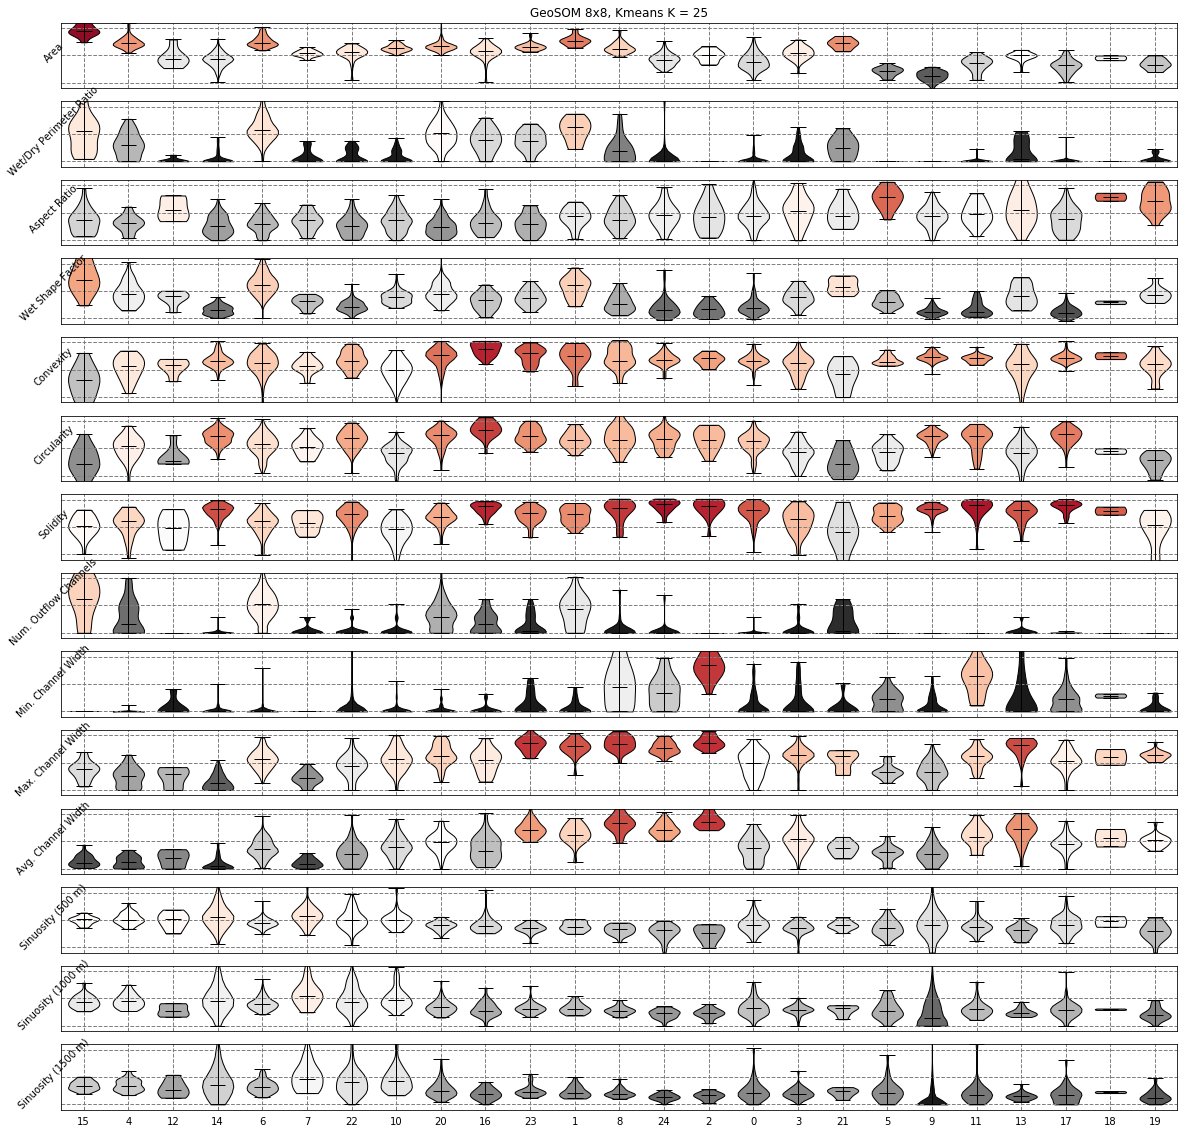

In [364]:
data = pd.DataFrame()

for col in classify_data2.columns:
    
    p1,p99 = np.percentile(classify_data2[col],[1,99])
    data[col] = (classify_data2[col] - p1) / (p99 - p1)
    
data['class'] = preds_full['8_25']



cmap = plt.cm.RdGy_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# class_range = [3,11,14,0,4,13,7,9,12,6,16,15,1,18,2,8,5,10,17,]

class_range = np.unique(data['class'])
class_range = [15,4,12,14, 6,7,22,10,20,16,23,1,8,24,2,0,3,21,5,9,11,13,17,18,19]

sort = np.argsort(class_range)
line_range = np.arange(-0.5, data['class'].max() + 1, 0.5)

fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(20, 20))

vals_all = []
for nn,col in enumerate(classify_data2.columns.values):

    vals = [list(data.loc[data['class'] == i, col]) for i in class_range]
    vals_med = [np.median(i) for i in vals]
    
    vals_all.append(vals_med)

    parts = axes[nn].violinplot(vals, np.unique(data['class']), points=20, widths=0.7,
                          showmeans=False, showextrema=True, showmedians=True,);

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)
    
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_xlim(-0.5,data['class'].max() + 0.5)
    axes[nn].set_ylim(-0.1,1.1)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    axes[nn].set_xticks(np.unique(data['class']))
    axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis('off');

    h = axes[nn].set_ylabel(col)
    h.set_rotation(45)

axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
axes[nn].set_xticks(np.unique(data['class']))
axes[nn].set_xticklabels(class_range);

axes[0].set_title('GeoSOM 8x8, Kmeans K = 25')

plt.savefig('../pubs/violin_8x8_k25.png')




# vals_8 = np.array(vals_all)

# for i in range(vals_8.shape[0]):
#     vals_8[i,:] = (vals_8[i,:] - vals_8[i,:].min())/(vals_8[i,:].max() - vals_8[i,:].min())
    
# np.savetxt('../pubs/violin_8_19.csv', vals_8, delimiter=',')

In [2110]:


data = pd.DataFrame()

for col in classify_data2.columns:
    
    p1,p99 = np.percentile(classify_data2[col],[1,99])
    data[col] = (classify_data2[col] - p1) / (p99 - p1)

data['class'] = preds_full['6_17']



cmap = plt.cm.RdGy_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

class_range = [7,4,12,14,3,2,8,15,13,5,6,0,1,9,10,11,16,]
sort = np.argsort(class_range)
line_range = np.arange(-0.5, data['class'].max() + 1, 0.5)

fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(12, 18))

vals_all = []

for nn,col in enumerate(classify_data2.columns.values):

    vals = [list(data.loc[data['class'] == i, col]) for i in class_range]
    vals_med = [np.median(i) for i in vals]

    parts = axes[nn].violinplot(vals, np.unique(data['class']), points=20, widths=0.7,
                          showmeans=True, showextrema=True, showmedians=False,);
    
    vals_all.append(vals_med)

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)
    
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_xlim(-0.5,data['class'].max() + 0.5)
    axes[nn].set_ylim(-0.1,1.1)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    axes[nn].set_xticks(np.unique(data['class']))
    axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis('off');

    h = axes[nn].set_ylabel(col)
    h.set_rotation(45)

axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
axes[nn].set_xticks(np.unique(data['class']))
axes[nn].set_xticklabels(class_range);

axes[0].set_title('GeoSOM 6x6, Kmeans K = 17')

plt.savefig('../pubs/violin_6x6_k17.png')

vals_6 = np.array(vals_all)

for i in range(vals_6.shape[0]):
    vals_6[i,:] = (vals_6[i,:] - vals_6[i,:].min())/(vals_6[i,:].max() - vals_6[i,:].min())
    
np.savetxt('../pubs/violin_6_17.csv', vals_6, delimiter=',')

SankeyWidget(groups=[{'nodes': ['8^8_0', '8^8_14', '8^8_3', '8^8_11', '8^8_13', '8^8_4', '8^8_7', '8^8_12', '8^8_9', '8^8_18', '8^8_10', '8^8_6', '8^8_16', '8^8_15', '8^8_1', '8^8_2', '8^8_8', '8^8_5', '8^8_17'], 'type': 'process', 'id': '8', 'title': ''}, {'nodes': ['a^a_5', 'a^a_4', 'a^a_3', 'a^a_2', 'a^a_96', 'a^a_94', 'a^a_17', 'a^a_16', 'a^a_73', 'a^a_72', 'a^a_87', 'a^a_86', 'a^a_85', 'a^a_84', 'a^a_20', 'a^a_19', 'a^a_50', 'a^a_49', 'a^a_45', 'a^a_44', 'a^a_43', 'a^a_83', 'a^a_79', 'a^a_77', 'a^a_76', 'a^a_65', 'a^a_62', 'a^a_60', 'a^a_59', 'a^a_57', 'a^a_108', 'a^a_70', 'a^a_66', 'a^a_34', 'a^a_33', 'a^a_32', 'a^a_31', 'a^a_102', 'a^a_101', 'a^a_99', 'a^a_97', 'a^a_8', 'a^a_12', 'a^a_10', 'a^a_9', 'a^a_52', 'a^a_29', 'a^a_28', 'a^a_27', 'a^a_26', 'a^a_105'], 'type': 'process', 'id': 'a', 'title': ''}, {'nodes': ['6^6_14', '6^6_12', '6^6_11', '6^6_7', '6^6_16', '6^6_4', '6^6_13', '6^6_5', '6^6_3', '6^6_15', '6^6_6', '6^6_8', '6^6_2', '6^6_1', '6^6_0'], 'type': 'process', 'id': '6', 'title': ''}], layout=Layout(height=u'500', width=u'1100'), links=[{'opacity': 1.0, 'source': 'a^a_2', 'target': '6^6_7', 'time': '*', 'color': '#45b7c3', 'title': '*', 'type': '*', 'value': 25.0}, {'opacity': 1.0, 'source': 'a^a_3', 'target': '6^6_11', 'time': '*', 'color': '#b1e0b8', 'title': '*', 'type': '*', 'value': 11.0}, {'opacity': 1.0, 'source': 'a^a_4', 'target': '6^6_12', 'time': '*', 'color': '#253494', 'title': '*', 'type': '*', 'value': 110.0}, {'opacity': 1.0, 'source': 'a^a_5', 'target': '6^6_14', 'time': '*', 'color': '#ecf7c7', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': 'a^a_8', 'target': '6^6_13', 'time': '*', 'color': '#ecf7c7', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': 'a^a_9', 'target': '6^6_1', 'time': '*', 'color': '#89d1b8', 'title': '*', 'type': '*', 'value': 15.0}, {'opacity': 1.0, 'source': 'a^a_99', 'target': '6^6_6', 'time': '*', 'color': '#3ba5c0', 'title': '*', 'type': '*', 'value': 32.0}, {'opacity': 1.0, 'source': 'a^a_94', 'target': '6^6_11', 'time': '*', 'color': '#92d4b7', 'title': '*', 'type': '*', 'value': 14.0}, {'opacity': 1.0, 'source': 'a^a_96', 'target': '6^6_16', 'time': '*', 'color': '#45b7c3', 'title': '*', 'type': '*', 'value': 25.0}, {'opacity': 1.0, 'source': 'a^a_97', 'target': '6^6_0', 'time': '*', 'color': '#9bd8b5', 'title': '*', 'type': '*', 'value': 13.0}, {'opacity': 1.0, 'source': 'a^a_76', 'target': '6^6_4', 'time': '*', 'color': '#3ba5c0', 'title': '*', 'type': '*', 'value': 32.0}, {'opacity': 1.0, 'source': 'a^a_77', 'target': '6^6_5', 'time': '*', 'color': '#70c8bc', 'title': '*', 'type': '*', 'value': 18.0}, {'opacity': 1.0, 'source': 'a^a_72', 'target': '6^6_4', 'time': '*', 'color': '#92d4b7', 'title': '*', 'type': '*', 'value': 14.0}, {'opacity': 1.0, 'source': 'a^a_73', 'target': '6^6_7', 'time': '*', 'color': '#70c8bc', 'title': '*', 'type': '*', 'value': 18.0}, {'opacity': 1.0, 'source': 'a^a_70', 'target': '6^6_15', 'time': '*', 'color': '#ffffcc', 'title': '*', 'type': '*', 'value': 6.0}, {'opacity': 1.0, 'source': 'a^a_79', 'target': '6^6_7', 'time': '*', 'color': '#cbebbf', 'title': '*', 'type': '*', 'value': 9.0}, {'opacity': 1.0, 'source': 'a^a_83', 'target': '6^6_15', 'time': '*', 'color': '#55bec1', 'title': '*', 'type': '*', 'value': 22.0}, {'opacity': 1.0, 'source': 'a^a_87', 'target': '6^6_13', 'time': '*', 'color': '#cbebbf', 'title': '*', 'type': '*', 'value': 9.0}, {'opacity': 1.0, 'source': 'a^a_86', 'target': '6^6_5', 'time': '*', 'color': '#3aa3c0', 'title': '*', 'type': '*', 'value': 33.0}, {'opacity': 1.0, 'source': 'a^a_85', 'target': '6^6_4', 'time': '*', 'color': '#69c5bd', 'title': '*', 'type': '*', 'value': 19.0}, {'opacity': 1.0, 'source': 'a^a_84', 'target': '6^6_3', 'time': '*', 'color': '#49b9c3', 'title': '*', 'type': '*', 'value': 24.0}, {'opacity': 1.0, 'source': 'a^a_65', 'target': '6^6_15', 'time': '*', 'color': '#a5dcb5', 'title': '*', 'type': '*', 'value': 12.0}, {'opacity': 1.0, 'source'

In [1986]:
vals = pd.crosstab(preds_full['8_19'],preds_full['6_17']).values

sums = vals.sum(axis=1).astype('float')
vals_pc_row = np.zeros(vals.shape)

for row in range(vals.shape[0]):
    vals_pc_row[row,:] = vals[row,:] / sums[row] * 100

percent_8_as_6 = {}

for row in range(vals_pc_row.shape[0]):
    
    percent_8_as_6[row] = dict(zip(list(np.where(vals_pc_row[row,:] > 0)[0]),
                                   list(vals_pc_row[row,:][vals_pc_row[row,:] > 0])))

    
    
    
    
sums = vals.sum(axis=0).astype('float')
vals_pc_col = np.zeros(vals.shape)

for col in range(vals.shape[1]):
    
    vals_pc_col[:,col] = vals[:,col] / sums[col] * 100
    
percent_6_as_8 = {}

for col in range(vals_pc_col.shape[1]):
    
    percent_6_as_8[col] = dict(zip(list(np.where(vals_pc_col[:,col] > 0)[0]),
                                   list(vals_pc_col[:,col][vals_pc_col[:,col] > 0])))
    

locs = np.where(vals > 0)

class0 = preds_full['8_19']
class1 = preds_full['6_17']

new_class = np.zeros_like(preds_full['8_19'])
count_new_class = {}

for n,i in enumerate(range(len(locs[0]))):
    
    inds = (class0 == locs[0][i]) & (class1 == locs[1][i])
    new_class[inds] = n
    
    count_new_class[n] = sum(inds)

count_new_class_all = np.zeros_like(preds_full['8_19'])

for i in np.unique(new_class):
    count_new_class_all[new_class == i] = count_new_class[i]

thresh = 10

new_class_thresh_10 = new_class.copy()
new_class_thresh_10[count_new_class_all < thresh] = -1


thresh = 20

new_class_thresh_20 = new_class.copy()
new_class_thresh_20[count_new_class_all < thresh] = -1

In [1988]:
fields = pd.DataFrame()
fields['all'] = new_class
fields['8_19'] = preds_full['8_19']
fields['6_17'] = preds_full['6_17']
fields['count'] = count_new_class_all
fields['t_10'] = new_class_thresh_10
fields['t_20'] = new_class_thresh_20

field_type = {}

for k in fields.columns:
    field_type[k] = ogr.OFTReal
    

create_shapefile_from_shapely_multi(islands,
                                    '../pubs/intersect_8_19__6_17.shp',
                                    fields = fields,
                                    field_type = field_type)

In [2135]:
flows = pd.DataFrame()
processes = pd.DataFrame()
nodes = None

thresh = 5

source_i = []
target_i = []
value = []
color = []
node_type = []

unique_rows = {}

    
vals = pd.crosstab(fields['8_19'],fields['all']).values

source_i += ['8' + '_' + str(l) for l in list(np.where(vals > thresh)[0])]
target_i += ['a' + '_' + str(l) for l in list(np.where(vals > thresh)[1])]
value += list(vals[vals > thresh])
color += list(np.log10(vals[vals > thresh]))
node_type += [('8', '8' + '_' + str(l)) for l in set(np.where(vals > thresh)[0])]

vals = pd.crosstab(fields['all'],fields['6_17'],).values

source_i += ['a' + '_' + str(l) for l in list(np.where(vals > thresh)[0])]
target_i += ['6' + '_' + str(l) for l in list(np.where(vals > thresh)[1])]
value += list(vals[vals > thresh])
color += list(np.log10(vals[vals > thresh]))
node_type += [('a', 'a' + '_' + str(l)) for l in set(np.where(vals > thresh)[0])]
node_type += [('6', '6' + '_' + str(l)) for l in set(np.where(vals > thresh)[1])] 

flows['source'] = source_i
flows['target'] = target_i
flows['value'] = value
flows['color'] = color


# Set the default size to fit the documentation better.
size = dict(width=1100, height=500)



processes = pd.DataFrame(data = np.array(node_type)[:,0], index = np.array(node_type)[:,1], columns=['type'])

dataset = Dataset(flows, dim_process=processes)

nodes = {
    '8': ProcessGroup('type == "8"'),
    'a': ProcessGroup('type == "a"'),
    '6': ProcessGroup('type == "6"'),

}

ordering = [['8'],['a'],['6']]
    
bundles = [
    Bundle('8','a'),
    Bundle('a','6'),

]

ur8 = [0,14,3,11,13,4,7,12,9,18,10,6,16,15,1,2,8,5,17,]


unique_rows['8'] = ['8' + '_' + str(l) for l in ur8]


vals = pd.crosstab(fields['8_19'],fields['all']).values
used_vals = []
ura = []

for i in ur8:

    ura_ = np.where(vals[i,:] > thresh)[0]
    
    for i_ in np.sort(ura_)[::-1]:

        if i_ not in used_vals:

            ura += [i_]
            used_vals.append(i_)
        
unique_rows['a'] = ['a' + '_' + str(l) for l in ura]
    
    

    
vals = pd.crosstab(fields['6_17'],fields['all']).values
used_vals = []
ur6 = []

for i in ura:

    ur6_ = np.where(vals[:,i] > thresh)[0]
    
    for i_ in np.sort(ur6_)[::-1]:

        if i_ not in used_vals:

            ur6 += [i_]
            used_vals.append(i_)
        
unique_rows['6'] = ['6' + '_' + str(l) for l in ur6]


for k in unique_rows.keys():
    
    
    by_class = Partition.Simple('process', unique_rows[k])
    nodes[k].partition = by_class
                     
                     
sdd = SankeyDefinition(nodes, bundles, ordering)
weave(sdd, dataset,
      measures={'value':'sum', 'color': 'sum'},
      link_width= 'value',
      link_color = QuantitativeScale('color', palette='YlGnBu_5')
     ).to_widget(**size) 

SankeyWidget(groups=[{'nodes': ['8^8_0', '8^8_14', '8^8_3', '8^8_11', '8^8_13', '8^8_4', '8^8_7', '8^8_12', '8^8_9', '8^8_18', '8^8_10', '8^8_6', '8^8_16', '8^8_15', '8^8_1', '8^8_2', '8^8_8', '8^8_5', '8^8_17'], 'type': 'process', 'id': '8', 'title': ''}, {'nodes': ['a^a_5', 'a^a_4', 'a^a_3', 'a^a_2', 'a^a_96', 'a^a_94', 'a^a_17', 'a^a_16', 'a^a_73', 'a^a_72', 'a^a_87', 'a^a_86', 'a^a_85', 'a^a_84', 'a^a_20', 'a^a_19', 'a^a_50', 'a^a_49', 'a^a_45', 'a^a_44', 'a^a_43', 'a^a_83', 'a^a_79', 'a^a_77', 'a^a_76', 'a^a_65', 'a^a_62', 'a^a_60', 'a^a_59', 'a^a_57', 'a^a_108', 'a^a_70', 'a^a_66', 'a^a_34', 'a^a_33', 'a^a_32', 'a^a_31', 'a^a_102', 'a^a_101', 'a^a_99', 'a^a_97', 'a^a_8', 'a^a_12', 'a^a_10', 'a^a_9', 'a^a_52', 'a^a_29', 'a^a_28', 'a^a_27', 'a^a_26', 'a^a_105'], 'type': 'process', 'id': 'a', 'title': ''}, {'nodes': ['6^6_14', '6^6_12', '6^6_11', '6^6_7', '6^6_16', '6^6_4', '6^6_13', '6^6_5', '6^6_3', '6^6_15', '6^6_6', '6^6_8', '6^6_2', '6^6_1', '6^6_0'], 'type': 'process', 'id': '6', 'title': ''}], layout=Layout(height=u'500', width=u'1100'), links=[{'opacity': 1.0, 'source': 'a^a_2', 'target': '6^6_7', 'time': '*', 'color': '#45b7c3', 'title': '*', 'type': '*', 'value': 25.0}, {'opacity': 1.0, 'source': 'a^a_3', 'target': '6^6_11', 'time': '*', 'color': '#b1e0b8', 'title': '*', 'type': '*', 'value': 11.0}, {'opacity': 1.0, 'source': 'a^a_4', 'target': '6^6_12', 'time': '*', 'color': '#253494', 'title': '*', 'type': '*', 'value': 110.0}, {'opacity': 1.0, 'source': 'a^a_5', 'target': '6^6_14', 'time': '*', 'color': '#ecf7c7', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': 'a^a_8', 'target': '6^6_13', 'time': '*', 'color': '#ecf7c7', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': 'a^a_9', 'target': '6^6_1', 'time': '*', 'color': '#89d1b8', 'title': '*', 'type': '*', 'value': 15.0}, {'opacity': 1.0, 'source': 'a^a_99', 'target': '6^6_6', 'time': '*', 'color': '#3ba5c0', 'title': '*', 'type': '*', 'value': 32.0}, {'opacity': 1.0, 'source': 'a^a_94', 'target': '6^6_11', 'time': '*', 'color': '#92d4b7', 'title': '*', 'type': '*', 'value': 14.0}, {'opacity': 1.0, 'source': 'a^a_96', 'target': '6^6_16', 'time': '*', 'color': '#45b7c3', 'title': '*', 'type': '*', 'value': 25.0}, {'opacity': 1.0, 'source': 'a^a_97', 'target': '6^6_0', 'time': '*', 'color': '#9bd8b5', 'title': '*', 'type': '*', 'value': 13.0}, {'opacity': 1.0, 'source': 'a^a_76', 'target': '6^6_4', 'time': '*', 'color': '#3ba5c0', 'title': '*', 'type': '*', 'value': 32.0}, {'opacity': 1.0, 'source': 'a^a_77', 'target': '6^6_5', 'time': '*', 'color': '#70c8bc', 'title': '*', 'type': '*', 'value': 18.0}, {'opacity': 1.0, 'source': 'a^a_72', 'target': '6^6_4', 'time': '*', 'color': '#92d4b7', 'title': '*', 'type': '*', 'value': 14.0}, {'opacity': 1.0, 'source': 'a^a_73', 'target': '6^6_7', 'time': '*', 'color': '#70c8bc', 'title': '*', 'type': '*', 'value': 18.0}, {'opacity': 1.0, 'source': 'a^a_70', 'target': '6^6_15', 'time': '*', 'color': '#ffffcc', 'title': '*', 'type': '*', 'value': 6.0}, {'opacity': 1.0, 'source': 'a^a_79', 'target': '6^6_7', 'time': '*', 'color': '#cbebbf', 'title': '*', 'type': '*', 'value': 9.0}, {'opacity': 1.0, 'source': 'a^a_83', 'target': '6^6_15', 'time': '*', 'color': '#55bec1', 'title': '*', 'type': '*', 'value': 22.0}, {'opacity': 1.0, 'source': 'a^a_87', 'target': '6^6_13', 'time': '*', 'color': '#cbebbf', 'title': '*', 'type': '*', 'value': 9.0}, {'opacity': 1.0, 'source': 'a^a_86', 'target': '6^6_5', 'time': '*', 'color': '#3aa3c0', 'title': '*', 'type': '*', 'value': 33.0}, {'opacity': 1.0, 'source': 'a^a_85', 'target': '6^6_4', 'time': '*', 'color': '#69c5bd', 'title': '*', 'type': '*', 'value': 19.0}, {'opacity': 1.0, 'source': 'a^a_84', 'target': '6^6_3', 'time': '*', 'color': '#49b9c3', 'title': '*', 'type': '*', 'value': 24.0}, {'opacity': 1.0, 'source': 'a^a_65', 'target': '6^6_15', 'time': '*', 'color': '#a5dcb5', 'title': '*', 'type': '*', 'value': 12.0}, {'opacity': 1.0, 'source'

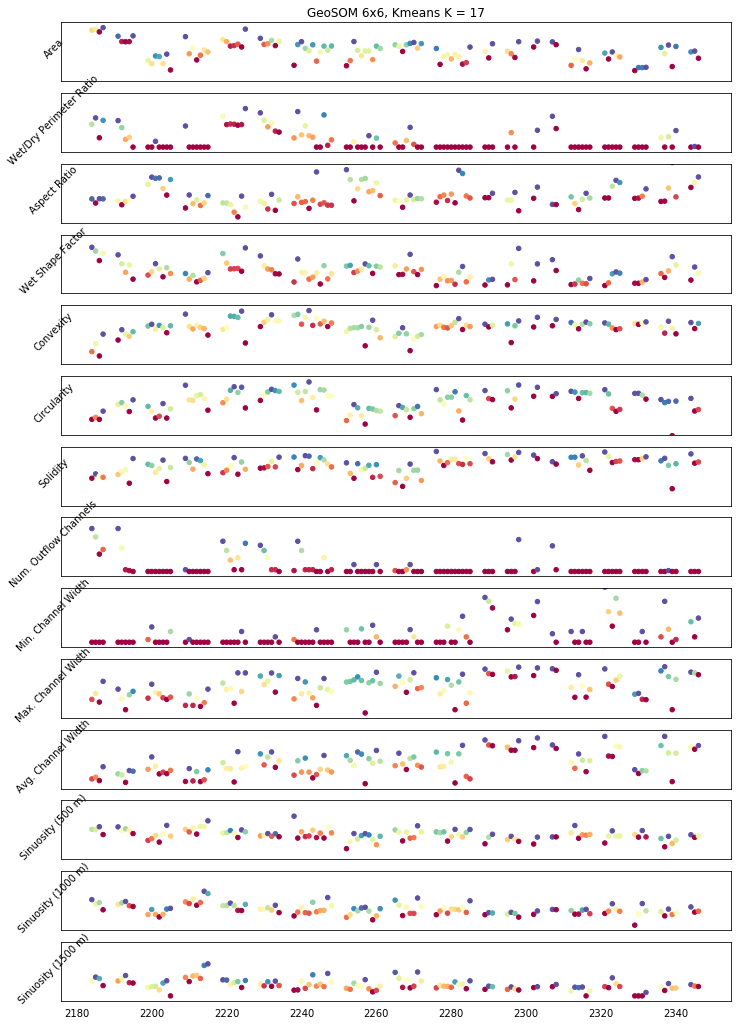

In [2170]:
data = pd.DataFrame()

for col in classify_data2.columns:
    
    p1,p99 = np.percentile(classify_data2[col],[1,99])
    data[col] = (classify_data2[col] - p1) / (p99 - p1)

data['class'] = fields['all']



cmap = plt.cm.RdGy_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

class_range = [3,11,14,0,4,13,7,9,12,6,16,15,1,18,2,8,5,10,17,]

fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(12, 18))

vals_all = []
counter = 0

for nn,col in enumerate(classify_data2.columns.values):
    
    for c in class_range:
        
        cr = list(np.unique(fields.loc[fields['8_19'] == c,'all']))
        vals_all += cr + [1000 + counter]

        vals = [list(data.loc[data['class'] == i, col]) for i in cr]
        vals_med = [np.median(i) for i in vals]

        axes[nn].scatter(counter + np.arange(len(vals_med)), vals_med, c = vals_med, s=20, cmap = 'Spectral')
        counter = counter + (len(vals_med) + 1) + 2
        
    counter += 2

#     parts = axes[nn].violinplot(vals, range(len(class_range)), points=20, widths=0.7,
#                           showmeans=True, showextrema=True, showmedians=False,);
    
#     vals_all.append(vals_med)

#     for n,pc in enumerate(parts['bodies']):
#         pc.set_facecolor(cmap(norm(vals_med[n])))
#         pc.set_edgecolor('black')
#         pc.set_alpha(1)
#         pc.set_linewidth(1)

#     for c in parts.keys():
#         if c != 'bodies':
#             vp = parts[c]
#             vp.set_edgecolor('black')
#             vp.set_linewidth(1)
    
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
#     axes[nn].set_xlim(class_range.min() - 0.5,class_range.max() + 0.5)
    axes[nn].set_ylim(-0.1,1.1)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
#     axes[nn].set_xticks(np.unique(vals_all))
#     axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis('off');

    h = axes[nn].set_ylabel(col)
    h.set_rotation(45)

axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
# axes[nn].set_xticks(np.unique(vals_all))
# axes[nn].set_xticklabels(vals_all);

axes[0].set_title('GeoSOM 6x6, Kmeans K = 17')

plt.savefig('../pubs/test.png', dpi = 300)

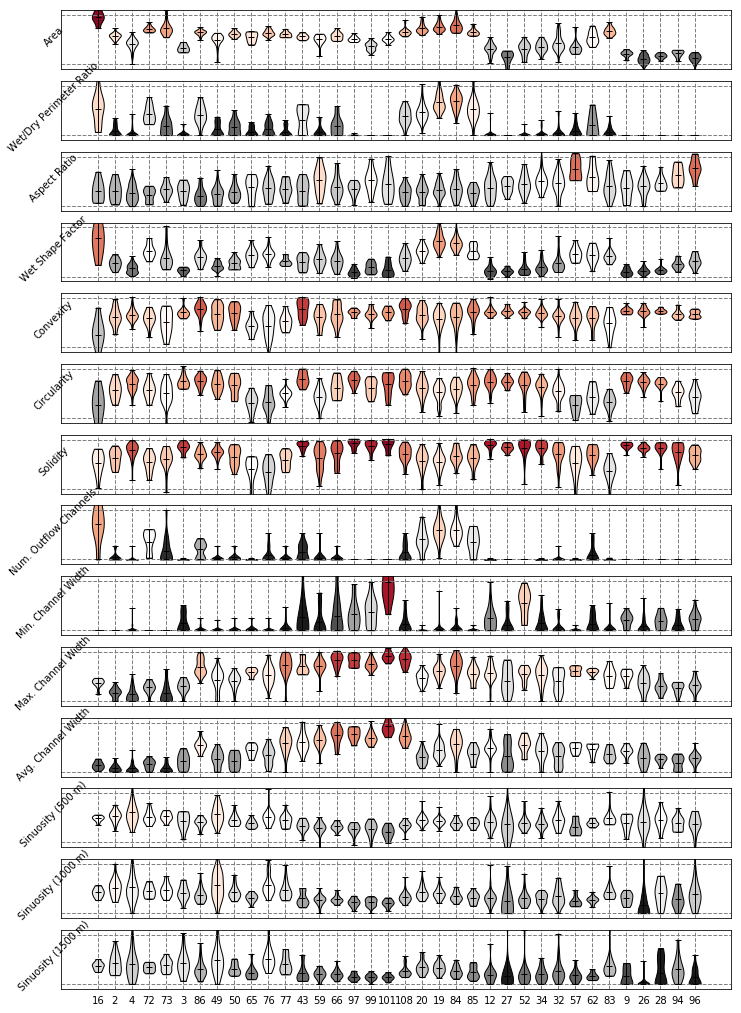

In [2178]:
data = pd.DataFrame()

for col in classify_data2.columns:
    
    p1,p99 = np.percentile(classify_data2[col],[1,99])
    data[col] = (classify_data2[col] - p1) / (p99 - p1)

data['class'] = fields['all']



cmap = plt.cm.RdGy_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

class_range_groups = [[16], # inactive
                       [2,4,72,73,3], # transition
                       [86,49,50,65,76,77], # tidal
                       [43,59,66,97,99,101,108], # tidal / mid-channel bars
                       [20,19,84,85], # mixed fluvial/tidal
                       [12,27,52,34], # mixed fluvial / tidal - small
                       [32,57,62,83], # fluvial
                       [9,26,28,94,96]] # fluvial, small


class_range = [item for sublist in class_range_groups for item in sublist]

fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(12, 18))

vals_all = []
counter = 0

for nn,col in enumerate(classify_data2.columns.values):
    
    vals = [list(data.loc[data['class'] == i, col]) for i in class_range]
    vals_med = [np.median(i) for i in vals]
    
    

    parts = axes[nn].violinplot(vals, np.arange(len(class_range)), points=20, widths=0.7,
                          showmeans=True, showextrema=True, showmedians=False,);
    
#     counter = counter + (len(class_range) + 1)
    
    vals_all.append(vals_med)

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)
    
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
#     axes[nn].set_xlim(class_range.min() - 0.5,class_range.max() + 0.5)
    axes[nn].set_ylim(-0.1,1.1)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    axes[nn].set_xticks(np.arange(len(class_range)))
    axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis('off');

    h = axes[nn].set_ylabel(col)
    h.set_rotation(45)

axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
axes[nn].set_xticks(np.arange(len(class_range)))
axes[nn].set_xticklabels(class_range);

# axes[0].set_title('GeoSOM 6x6, Kmeans K = 17')

plt.savefig('../pubs/test.png', dpi = 300)

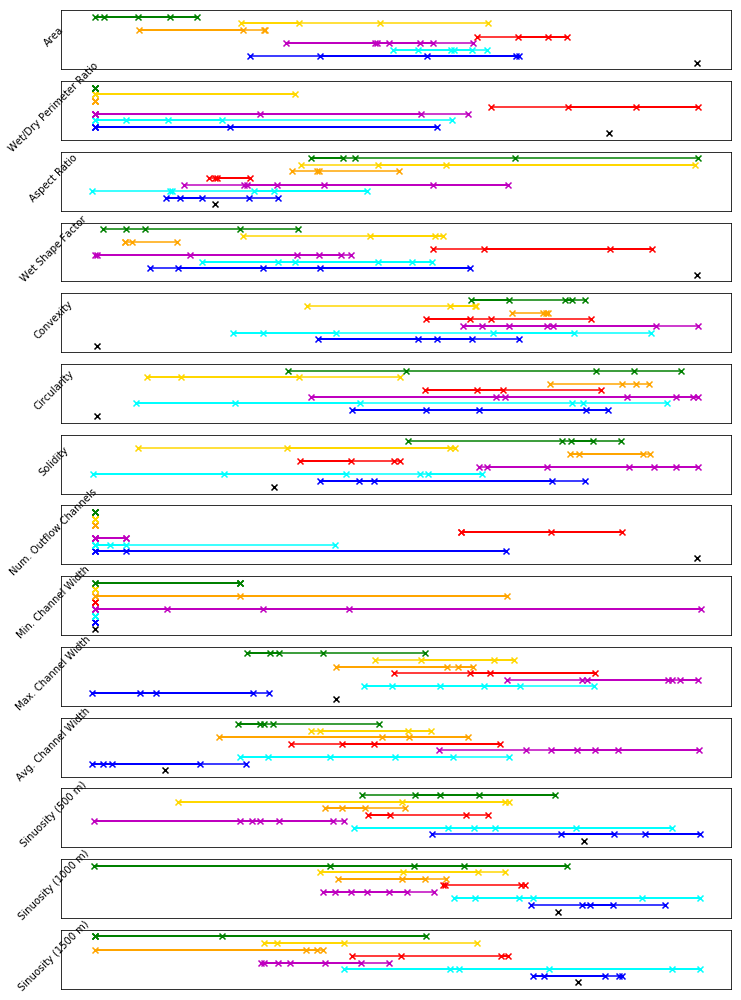

In [2196]:
fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(12, 18))

colors = ['k','b','cyan','m','r','orange','gold','green',]

for nn,col in enumerate(classify_data2.columns.values):

    for nnl,l in enumerate(class_range_groups):
        
        vals = [list(data.loc[data['class'] == i, col]) for i in l]
        vals_med = [np.median(i) for i in vals]

        axes[nn].scatter(vals_med, nnl + np.zeros((len(vals_med),)), c = colors[nnl], vmin = 0, vmax = 7, marker = 'x')
        axes[nn].plot(vals_med, nnl + np.zeros((len(vals_med),)), c = colors[nnl])
    axes[nn].set_ylim(-1,8)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    
    h = axes[nn].set_ylabel(col)
    h.set_rotation(45)    

In [ ]:
# metric
# find the combination of clustering algorithms that minimizes the standard deviation within each class,
# maximizes the euclidean distance between different classes, and minimizes the geographic spread of the class


internal_std_all_pca = pd.DataFrame(columns=preds_full.columns)
external_dist_all_pca = pd.DataFrame(columns=preds_full.columns)

for algorithm in preds_full.columns.values:

    classes = np.unique(preds_full[algorithm])
    internal_std = pd.DataFrame(columns=reduced_data.columns)

    for i in classes:

        for param in reduced_data.columns.values:

            vals = reduced_data.loc[preds_full[algorithm] == i, param]
            internal_std.loc[i,param] = np.std(vals)

    internal_std_all_pca.loc[0,algorithm] = np.mean(internal_std.values)

    external_dist = []

    for it1, it2 in itertools.combinations(classes, 2):

        dist = []

        for param in reduced_data.columns.values:
            dist.append(np.sqrt((np.mean(reduced_data.loc[preds_full[algorithm] == it1,param]) -
                                 np.mean(reduced_data.loc[preds_full[algorithm] == it2,param]))**2))

        external_dist.append(np.mean(dist))

    external_dist_all_pca.loc[0,algorithm] = np.mean(external_dist)

In [ ]:
for algorithm in preds_kmeans_only.columns.values:

    classes = np.unique(preds_kmeans_only[algorithm])
    internal_std = pd.DataFrame(columns=reduced_data.columns)

    for i in classes:

        for param in reduced_data.columns.values:

            vals = reduced_data.loc[preds_kmeans_only[algorithm] == i, param]
            internal_std.loc[i,param] = np.std(vals)

    internal_std_all_pca.loc[0,algorithm] = np.mean(internal_std.values)

    external_dist = []

    for it1, it2 in itertools.combinations(classes, 2):

        dist = []

        for param in reduced_data.columns.values:
            dist.append(np.sqrt((np.mean(reduced_data.loc[preds_kmeans_only[algorithm] == it1,param]) -
                                 np.mean(reduced_data.loc[preds_kmeans_only[algorithm] == it2,param]))**2))

        external_dist.append(np.mean(dist))

    external_dist_all_pca.loc[0,algorithm] = np.mean(external_dist)
    
    
for algorithm in regions_all.columns.values:

    classes = np.unique(regions_all[algorithm])
    internal_std = pd.DataFrame(columns=reduced_data.columns)

    for i in classes:

        for param in reduced_data.columns.values:

            vals = reduced_data.loc[regions_all[algorithm] == i, param]
            internal_std.loc[i,param] = np.std(vals)

    internal_std_all_pca.loc[0,algorithm] = np.mean(internal_std.values)

    external_dist = []

    for it1, it2 in itertools.combinations(classes, 2):

        dist = []

        for param in reduced_data.columns.values:
            dist.append(np.sqrt((np.mean(reduced_data.loc[regions_all[algorithm] == it1,param]) -
                                 np.mean(reduced_data.loc[regions_all[algorithm] == it2,param]))**2))

        external_dist.append(np.mean(dist))

    external_dist_all_pca.loc[0,algorithm] = np.mean(external_dist)

In [ ]:
pd.to_pickle(external_dist_all_pca, 'ganges_metrics/metrics_geosom_all/external_euclidean_distances_pca.p')
pd.to_pickle(internal_std_all_pca, 'ganges_metrics/metrics_geosom_all/internal_std_pca.p')

In [ ]:
# metric
# find the combination of clustering algorithms that minimizes the standard deviation within each class,
# maximizes the euclidean distance between different classes, and minimizes the geographic spread of the class


internal_std_all = pd.DataFrame(columns=preds_full.columns)
external_dist_all = pd.DataFrame(columns=preds_full.columns)

for algorithm in preds_full.columns.values:

    classes = np.unique(preds_full[algorithm])
    internal_std = pd.DataFrame(columns=classify_data2.columns)

    for i in classes:

        for param in classify_data2.columns.values:

            vals = classify_data2.loc[preds_full[algorithm] == i, param]
            internal_std.loc[i,param] = np.std(vals)

    internal_std_all.loc[0,algorithm] = np.mean(internal_std.values)

    external_dist = []

    for it1, it2 in itertools.combinations(classes, 2):

        dist = []

        for param in classify_data2.columns.values:
            dist.append(np.sqrt((np.mean(classify_data2.loc[preds_full[algorithm] == it1,param]) -
                                 np.mean(classify_data2.loc[preds_full[algorithm] == it2,param]))**2))

        external_dist.append(np.mean(dist))

    external_dist_all.loc[0,algorithm] = np.mean(external_dist)

In [ ]:
for algorithm in preds_kmeans_only.columns.values:

    classes = np.unique(preds_kmeans_only[algorithm])
    internal_std = pd.DataFrame(columns=classify_data2.columns)

    for i in classes:

        for param in classify_data2.columns.values:

            vals = classify_data2.loc[preds_kmeans_only[algorithm] == i, param]
            internal_std.loc[i,param] = np.std(vals)

    internal_std_all.loc[0,algorithm] = np.mean(internal_std.values)

    external_dist = []

    for it1, it2 in itertools.combinations(classes, 2):

        dist = []

        for param in classify_data2.columns.values:
            dist.append(np.sqrt((np.mean(classify_data2.loc[preds_kmeans_only[algorithm] == it1,param]) -
                                 np.mean(classify_data2.loc[preds_kmeans_only[algorithm] == it2,param]))**2))

        external_dist.append(np.mean(dist))

    external_dist_all.loc[0,algorithm] = np.mean(external_dist)
    
    
for algorithm in regions_all.columns.values:

    classes = np.unique(regions_all[algorithm])
    internal_std = pd.DataFrame(columns=classify_data2.columns)

    for i in classes:

        for param in classify_data2.columns.values:

            vals = classify_data2.loc[regions_all[algorithm] == i, param]
            internal_std.loc[i,param] = np.std(vals)

    internal_std_all.loc[0,algorithm] = np.mean(internal_std.values)

    external_dist = []

    for it1, it2 in itertools.combinations(classes, 2):

        dist = []

        for param in classify_data2.columns.values:
            dist.append(np.sqrt((np.mean(classify_data2.loc[regions_all[algorithm] == it1,param]) -
                                 np.mean(classify_data2.loc[regions_all[algorithm] == it2,param]))**2))

        external_dist.append(np.mean(dist))

    external_dist_all.loc[0,algorithm] = np.mean(external_dist)

In [ ]:
pd.to_pickle(external_dist_all, 'ganges_metrics/metrics_geosom_all/external_euclidean_distances.p')
pd.to_pickle(internal_std_all, 'ganges_metrics/metrics_geosom_all/internal_std.p')

In [ ]:
# calculating just the geographic distance doesn't work because algorithms with fewer classes might have larger groups


internal_geo_all = pd.DataFrame(columns=preds_full.columns, dtype = 'float')

for algorithm in preds_full.columns.values:

    classes = np.unique(preds_full[algorithm])
    stds = []

    for i in classes:

        loc = np.where(preds_full[algorithm] == i)[0]
        coords = np.zeros((len(loc),2))

        for n,l in enumerate(loc):

            coords[n,:] = islands[l].centroid.coords[0]
            
        stds.append(np.std(coords))
        
    internal_geo_all.loc[0,algorithm] = np.float(np.mean(stds))

In [ ]:
for algorithm in preds_kmeans_only.columns.values:

    classes = np.unique(preds_kmeans_only[algorithm])
    stds = []

    for i in classes:

        loc = np.where(preds_kmeans_only[algorithm] == i)[0]
        coords = np.zeros((len(loc),2))

        for n,l in enumerate(loc):

            coords[n,:] = islands[l].centroid.coords[0]
            
        stds.append(np.std(coords))
        
    internal_geo_all.loc[0,algorithm] = np.float(np.mean(stds))
    
    
for algorithm in regions_all.columns.values:

    classes = np.unique(regions_all[algorithm])
    stds = []

    for i in classes:

        loc = np.where(regions_all[algorithm] == i)[0]
        coords = np.zeros((len(loc),2))

        for n,l in enumerate(loc):

            coords[n,:] = islands[l].centroid.coords[0]
            
        stds.append(np.std(coords))
        
    internal_geo_all.loc[0,algorithm] = np.float(np.mean(stds))

In [ ]:
pd.to_pickle(internal_geo_all, 'ganges_metrics/metrics_geosom_all/internal_geo_spread.p')

In [ ]:
# calculating just the geographic distance doesn't work because algorithms with fewer classes might have larger groups


internal_geo_dist_all = pd.DataFrame(columns=preds_full.columns, dtype = 'float')

for algorithm in preds_full.columns.values:

    classes = np.unique(preds_full[algorithm])
    centroids = []

    for i in classes:

        loc = np.where(preds_full[algorithm] == i)[0]
        coords = np.zeros((len(loc),2))

        for n,l in enumerate(loc):

            coords[n,:] = islands[l].centroid.coords[0]
            
        centroids.append(list(np.mean(coords,axis=0)))
    
    centroids = np.array(centroids)
    
    dist = []
    
    for it1, it2 in itertools.combinations(classes, 2):

        dist.append(np.sqrt((centroids[it1,0] - centroids[it2,0])**2 + (centroids[it1,1] - centroids[it2,1])**2))
            
            
    internal_geo_dist_all.loc[0,algorithm] = np.mean(dist)

In [ ]:
for algorithm in preds_kmeans_only.columns.values:

    classes = np.unique(preds_kmeans_only[algorithm])
    centroids = []

    for i in classes:

        loc = np.where(preds_kmeans_only[algorithm] == i)[0]
        coords = np.zeros((len(loc),2))

        for n,l in enumerate(loc):

            coords[n,:] = islands[l].centroid.coords[0]
            
        centroids.append(list(np.mean(coords,axis=0)))
    
    centroids = np.array(centroids)
    
    dist = []
    
    for it1, it2 in itertools.combinations(classes, 2):

        dist.append(np.sqrt((centroids[it1,0] - centroids[it2,0])**2 + (centroids[it1,1] - centroids[it2,1])**2))
            
            
    internal_geo_dist_all.loc[0,algorithm] = np.mean(dist)
    
    
for algorithm in regions_all.columns.values:

    classes = np.unique(regions_all[algorithm])
    centroids = []

    for i in classes:

        loc = np.where(regions_all[algorithm] == i)[0]
        coords = np.zeros((len(loc),2))

        for n,l in enumerate(loc):

            coords[n,:] = islands[l].centroid.coords[0]
            
        centroids.append(list(np.mean(coords,axis=0)))
    
    centroids = np.array(centroids)
    
    dist = []
    
    for it1, it2 in itertools.combinations(classes, 2):

        dist.append(np.sqrt((centroids[it1,0] - centroids[it2,0])**2 + (centroids[it1,1] - centroids[it2,1])**2))
            
            
    internal_geo_dist_all.loc[0,algorithm] = np.mean(dist)

In [ ]:
pd.to_pickle(internal_geo_dist_all, 'ganges_metrics/metrics_geosom_all/internal_geo_dist_spread.p')

In [17]:
external_dist_all_pca = pd.read_pickle('ganges_metrics/metrics_geosom_all/external_euclidean_distances_pca.p')
internal_std_all_pca = pd.read_pickle('ganges_metrics/metrics_geosom_all/internal_std_pca.p')

external_dist_all = pd.read_pickle('ganges_metrics/metrics_geosom_all/external_euclidean_distances.p')
internal_std_all = pd.read_pickle('ganges_metrics/metrics_geosom_all/internal_std.p')

internal_geo_all = pd.read_pickle('ganges_metrics/metrics_geosom_all/internal_geo_spread.p')

internal_geo_dist_all = pd.read_pickle('ganges_metrics/metrics_geosom_all/internal_geo_dist_spread.p')

['8_25', '7_25', '6_23', '6_24', '8_24', '6_25', '6_22', '8_21', '7_24', '8_19', '8_23', '7_22', '7_23', '8_22', '8_14', '8_18', '6_20', '6_17', '8_17', '6_21', '8_20', '6_19', '6_16', '6_18', '7_19', '7_20', '7_21', '5_7', '5_16', '8_16', '5_17', '5_22', '5_21', '7_18', '4_9', '5_18', '5_23', '5_13', '6_15', '5_19', '5_15', '6_14', '8_15', '7_17', '5_8', '5_14', '5_20', '7_16', '5_6', '5_12', '4_10', '4_8', '7_13', '6_13', '8_13', '7_15', '6_11', '4_11', '8_12', '4_12', '5_11', '4_13', '4_7', '5_9', '6_12', '6_9', '5_10', '8_11', '4_14', '6_10', '7_10', '7_14', '8_10', '7_12', '8_7', '6_8', '4_6', '8_9', '8_8', '7_9', '7_8', '7_11', '4_5', '6_7', '7_7', '6_6', '6_5', '5_5', '7_6', '8_6', '8_5', '7_5']


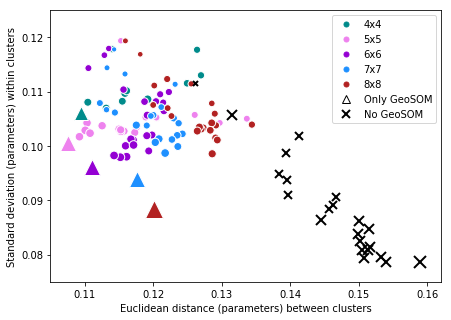

In [350]:
eu_dist = external_dist_all.values[0].astype('float')
eu_dist = (eu_dist - eu_dist.min()) / (eu_dist.max() - eu_dist.min())

std = internal_std_all.values[0].astype('float')
std = (std - std.min()) / (std.max() - std.min())

geo_dist = internal_geo_dist_all.values[0]
geo_dist = (geo_dist - geo_dist.min()) / (geo_dist.max() - geo_dist.min())

optimized = eu_dist - std + geo_dist
ind = np.argsort(optimized)[::-1]
scores = list(optimized[ind])
ordered_by_score = list(external_dist_all.columns.values[ind])

scored = [i for i in ordered_by_score if (('_' in i) and (i[-1] != '_'))]
print scored



geosom_number = [int(i[0]) if i[-1] is not '_' else 0 for i in external_dist_all.columns.values]
kmeans_number = [int(i[2:]) if (i[-1] is not '_') & (len(i) > 1) else (0 if len(i)==1 else int(i[:-1])) for i in external_dist_all.columns.values]

plt.figure(figsize=(7,5))

color = ['k' if i == 0 else (
        'b' if i == 4 else (
        'g' if i == 5 else (
        'gold' if i == 6 else (
        'orange' if i == 7 else (
        'r' if i == 8 else None))))) for i in geosom_number]

color = ['k' if i == 0 else (
        'darkcyan' if i == 4 else (
        'violet' if i == 5 else (
        'darkviolet' if i == 6 else (
        'dodgerblue' if i == 7 else (
        'firebrick' if i == 8 else None))))) for i in geosom_number]

a = internal_geo_dist_all.values[0]
sizes = ((a - a.min())/ (a.max() - a.min()) * 300) + 50

loc = (np.array(geosom_number) > 0) & (np.array(kmeans_number) > 0)

plt.scatter(external_dist_all.values[0][loc], internal_std_all.values[0][loc],
            c = np.array(color)[loc], s = sizes[loc], alpha = 1, marker = '.', edgecolor = 'w')
plt.xlabel('Euclidean distance (parameters) between clusters')
plt.ylabel('Standard deviation (parameters) within clusters')
plt.xlim(0.105,0.162)
plt.ylim(0.075,0.125)

for n in range(len(kmeans_number)):
    
    if geosom_number[n] == 0:
        plt.plot(external_dist_all.values[0][n], internal_std_all.values[0][n], 'x', c = color[n], ms = sizes[n] / 10, markeredgewidth = 2)
        
    if kmeans_number[n] == 0:
        plt.plot(external_dist_all.values[0][n], internal_std_all.values[0][n], '^', c = color[n], ms = sizes[n] / 20, alpha = 1, markeredgecolor = 'w')
        
        
    
plt.plot(0,0, '.', ms = 10, c = 'darkcyan', label = '4x4')
plt.plot(0,0, '.', ms = 10, c = 'violet', label = '5x5')
plt.plot(0,0, '.', ms = 10, c = 'darkviolet', label = '6x6')
plt.plot(0,0, '.', ms = 10, c = 'dodgerblue', label = '7x7')
plt.plot(0,0, '.', ms = 10, c = 'firebrick', label = '8x8')
plt.plot(0,0, '^', ms = 8, c = 'w', markeredgecolor = 'k', label = 'Only GeoSOM')
plt.plot(0,0, 'x', ms = 8, c = 'k', markeredgewidth = 2, label = 'No GeoSOM')

plt.legend()
plt.savefig('../pubs/spread.png')

['8_25', '7_25', '6_23', '6_24', '6_25', '6_22', '8_24', '7_24', '6_20', '7_22', '7_23', '6_17', '8_21', '8_23', '8_19', '6_21', '8_22', '5_21', '6_19', '6_18', '5_22', '5_23', '8_18', '6_16', '8_14', '8_17', '8_20', '5_17', '7_21', '7_20', '7_19', '5_16', '7_18', '5_18', '5_19', '5_20', '5_13', '5_15', '6_15', '8_16', '7_17', '4_9', '5_14', '7_16', '6_14', '5_7', '8_15', '7_13', '5_8', '7_15', '5_12', '5_6', '8_12', '6_13', '4_10', '4_13', '5_9', '5_11', '8_13', '7_10', '4_14', '4_12', '7_12', '4_11', '5_10', '6_11', '8_11', '7_14', '6_12', '4_8', '6_9', '8_10', '7_9', '6_8', '6_10', '8_9', '8_7', '4_7', '7_11', '8_8', '7_8', '4_6', '6_7', '4_5', '7_7', '7_6', '6_6', '8_6', '8_5', '5_5', '6_5', '7_5']


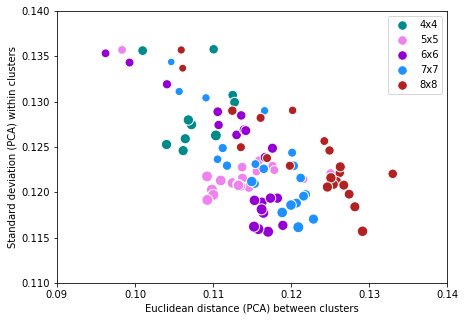

In [358]:
eu_dist = external_dist_all_pca.values[0].astype('float')
eu_dist = (eu_dist - eu_dist.min()) / (eu_dist.max() - eu_dist.min())

std = internal_std_all_pca.values[0].astype('float')
std = (std - std.min()) / (std.max() - std.min())

geo_dist = internal_geo_dist_all.values[0] / 2e6 + 0.05
geo_dist = (geo_dist - geo_dist.min()) / (geo_dist.max() - geo_dist.min())

optimized = eu_dist - std + geo_dist
ind = np.argsort(optimized)[::-1]
scores = list(optimized[ind])
ordered_by_score = list(external_dist_all_pca.columns.values[ind])

scored = [i for i in ordered_by_score if (('_' in i) and (i[-1] != '_'))]
print scored


plt.figure(figsize=(7,5))

color = ['k' if i == 0 else (
        'b' if i == 4 else (
        'g' if i == 5 else (
        'gold' if i == 6 else (
        'orange' if i == 7 else (
        'r' if i == 8 else None))))) for i in geosom_number]

color = ['k' if i == 0 else (
        'darkcyan' if i == 4 else (
        'violet' if i == 5 else (
        'darkviolet' if i == 6 else (
        'dodgerblue' if i == 7 else (
        'firebrick' if i == 8 else None))))) for i in geosom_number]

a = internal_geo_dist_all.values[0]
sizes = ((a - a.min())/ (a.max() - a.min()) * 400) + 150

loc = (np.array(geosom_number) > 0) & (np.array(kmeans_number) > 0)

plt.scatter(external_dist_all_pca.values[0][loc], internal_std_all_pca.values[0][loc],
            c = np.array(color)[loc], s = sizes[loc], alpha = 1, marker = '.', edgecolor = 'w')
plt.xlabel('Euclidean distance (PCA) between clusters')
plt.ylabel('Standard deviation (PCA) within clusters')
plt.xlim(0.09,0.17)
plt.ylim(0.09,0.14)

plt.xlim(0.09,0.14)
plt.ylim(0.11,0.14)

# for n in range(len(kmeans_number)):
    
#     if geosom_number[n] == 0:
#         plt.plot(external_dist_all_pca.values[0][n], internal_std_all_pca.values[0][n], 'x', c = color[n], ms = sizes[n] / 10, markeredgewidth = 2)
        
#     if kmeans_number[n] == 0:
#         plt.plot(external_dist_all_pca.values[0][n], internal_std_all_pca.values[0][n], '^', c = color[n], ms = sizes[n] / 20, alpha = 1, markeredgecolor = 'w')
        
        
    
plt.plot(0,0, '.', ms = 15, c = 'darkcyan', label = '4x4')
plt.plot(0,0, '.', ms = 15, c = 'violet', label = '5x5')
plt.plot(0,0, '.', ms = 15, c = 'darkviolet', label = '6x6')
plt.plot(0,0, '.', ms = 15, c = 'dodgerblue', label = '7x7')
plt.plot(0,0, '.', ms = 15, c = 'firebrick', label = '8x8')
# plt.plot(0,0, '^', ms = 8, c = 'w', markeredgecolor = 'k', label = 'Only GeoSOM')
# plt.plot(0,0, 'x', ms = 8, c = 'k', markeredgewidth = 2, label = 'No GeoSOM')

plt.legend()
plt.savefig('../pubs/spread_pca.png')

In [365]:
classes = preds_full['8_25']

In [370]:
import shapefile

files = ['ganges_metrics/metrics_geosom/islands_properties_all.shp']

data = pd.DataFrame()

for fname in files:
    
    sf = shapefile.Reader(fname)

    fields = [f[0] for f in sf.fields[1:]]
    
    for n,field in enumerate(fields):
        
        data[field] = [r.record[n] for r in sf.shapeRecords()]

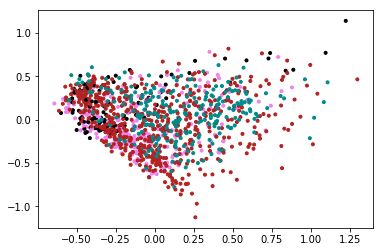

In [436]:
color = ['k' if i == 0 else (
        'violet' if ((i > 0) and (i < 0.5)) else (
        'darkcyan' if ((i > 0.5) and (i < 0.75)) else (
        'firebrick' if ((i > 0.75)) else None))) for i in data['zone']]

plt.scatter(reduced_data['PCA0'], reduced_data['PCA1'], c = color, marker = '.')

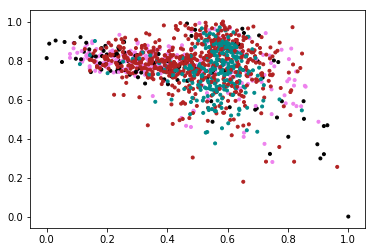

In [437]:
color = ['k' if i == 0 else (
        'violet' if ((i > 0) and (i < 0.5)) else (
        'darkcyan' if ((i > 0.5) and (i < 0.75)) else (
        'firebrick' if ((i > 0.75)) else None))) for i in data['zone']]

plt.scatter(classify_data2['Area'], classify_data2['Convexity'], c = color, marker = '.')

In [469]:
from sklearn.metrics import adjusted_mutual_info_score

cols = preds_full.columns

mutual_info_scores = np.ones((len(cols), len(cols)))

for i,j in itertools.combinations(range(len(cols)),2):
    
    score = adjusted_mutual_info_score(preds_full[cols[i]], preds_full[cols[j]])
    mutual_info_scores[i,j] = score
    mutual_info_scores[j,i] = score

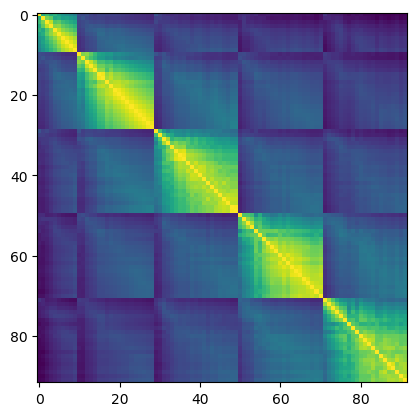

In [470]:
plt.imshow(mutual_info_scores)

In [491]:
cols = [
 '6_15',
 '6_16',
 '6_17',
 '6_18',
 '6_19',
 '6_20',
 '6_21',
 '6_22',
 '6_23',
 '6_24',
 '6_25',
 '7_15',
 '7_16',
 '7_17',
 '7_18',
 '7_19',
 '7_20',
 '7_21',
 '7_22',
 '7_23',
 '7_24',
 '7_25',
 '8_15',
 '8_16',
 '8_17',
 '8_18',
 '8_19',
 '8_20',
 '8_21',
 '8_22',
 '8_23',
 '8_24',
 '8_25']

In [493]:

# cols = preds_full.columns.tolist()

p_classes = pd.DataFrame()
p_classes['class'] = -1 * np.ones((len(preds_full),))

pd_persistent = preds_full[cols].duplicated()
indices_new_classes = list(preds_full[~pd_persistent].index)

for nn,i in enumerate(indices_new_classes):
    p_classes['class'][(preds_full == preds_full.loc[i]).sum(axis=1) == len(cols)] = nn



a = preds_full[cols]
b = a.values

h,w = b.shape

eye = np.eye(w, dtype=bool)
corr = np.ones((h, h)) * w

for i, j in itertools.permutations(range(h), r = 2):

    mask = b[i][:,None] == b[j]
    out = mask[eye]

    corr[i,j] = out.sum()

corr_ = corr / float(w)




df_corr = pd.DataFrame()

for i in range(len(corr_)):
    
    df_corr[str(i)] = corr_[i,:]

field_type = {}
for k in df_corr.keys():
    field_type[k] = ogr.OFTReal

create_shapefile_from_shapely_multi(islands,
                                    '../pubs/correlation.shp',
                                    fields = df_corr,
                                    field_type = field_type)

In [16]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


fig, ax = plt.subplots(3)
fig.set_size_inches(6, 36)

cluster_labels_ = [preds_full['6_17'],preds_full['7_25'],preds_full['8_25']]

for n,cluster_labels in enumerate(cluster_labels_):
    
    n_clusters = len(np.unique(cluster_labels))

    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)
    
    n_clusters = len(np.unique(cluster_labels))

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax[n].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples


    # The vertical line for average silhouette score of all the values
    ax[n].axvline(x=silhouette_avg, color="red", linestyle="--")



('For n_clusters =', 17, 'The average silhouette_score is :', -0.040583046230661307)
('For n_clusters =', 25, 'The average silhouette_score is :', -0.075774375384353776)
('For n_clusters =', 25, 'The average silhouette_score is :', -0.05789624253917959)


In [17]:
centroids = [list(i.centroid.coords[0]) for i in islands]

classify_data3 = classify_data2.copy()
classify_data3['easting'] = np.array(centroids)[:,0]
classify_data3['northing'] = np.array(centroids)[:,1]

for col in classify_data3.columns:
    classify_data3[col] = (classify_data3[col] - classify_data3[col].min()) / (classify_data3[col].max() - classify_data3[col].min())


classify_data4 = reduced_data.copy()
classify_data4['easting'] = np.array(centroids)[:,0]
classify_data4['northing'] = np.array(centroids)[:,1]

for col in classify_data4.columns:
    classify_data4[col] = (classify_data4[col] - classify_data4[col].min()) / (classify_data4[col].max() - classify_data4[col].min())

    
    
scores = pd.DataFrame(columns = preds_full.columns)


sil_cd2_df = pd.DataFrame(columns= preds_full.columns.values)
sil_red_df = pd.DataFrame(columns= preds_full.columns.values)
sil_cd3_df = pd.DataFrame(columns= preds_full.columns.values)
sil_geo_df = pd.DataFrame(columns= preds_full.columns.values)
sil_cd4_df = pd.DataFrame(columns= preds_full.columns.values)

for col in preds_full.columns:
    
    cd2 = silhouette_samples(classify_data2, preds_full[col])
    red = silhouette_samples(reduced_data, preds_full[col])
    cd3 = silhouette_samples(classify_data3, preds_full[col])
    cd4 = silhouette_samples(classify_data4, preds_full[col])
    geo = silhouette_samples(classify_data4[['easting','northing']], preds_full[col])
    
    
    sil_cd2 = np.zeros_like(preds_full[col]).astype('float')
    sil_red = np.zeros_like(preds_full[col]).astype('float')
    sil_cd3 = np.zeros_like(preds_full[col]).astype('float')
    sil_cd4 = np.zeros_like(preds_full[col]).astype('float')
    sil_geo = np.zeros_like(preds_full[col]).astype('float')
    

    for n in np.unique(preds_full[col]):

        ind = np.where(preds_full[col].values == n)[0]
        sil_cd2[ind] = cd2[n]
        sil_red[ind] = red[n]
        sil_cd3[ind] = cd3[n]
        sil_cd4[ind] = cd4[n]
        sil_geo[ind] = geo[n]

    sil_cd2_df[col] = sil_cd2
    sil_red_df[col] = sil_red
    sil_cd3_df[col] = sil_cd3
    sil_cd4_df[col] = sil_cd4
    sil_geo_df[col] = sil_geo

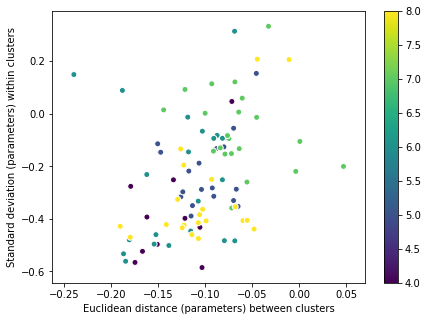

In [305]:
plt.figure(figsize=(7,5))

# color = ['k' if i == 0 else (
#         'b' if i == 4 else (
#         'g' if i == 5 else (
#         'gold' if i == 6 else (
#         'orange' if i == 7 else (
#         'r' if i == 8 else None))))) for i in geosom_number]

# color = ['k' if i == 0 else (
#         'darkcyan' if i == 4 else (
#         'violet' if i == 5 else (
#         'darkviolet' if i == 6 else (
#         'dodgerblue' if i == 7 else (
#         'firebrick' if i == 8 else None))))) for i in geosom_number]

# a = internal_geo_dist_all.values[0]
# sizes = ((a - a.min())/ (a.max() - a.min()) * 300) + 50

# loc = (np.array(geosom_number) > 0) & (np.array(kmeans_number) > 0)

plt.scatter(sil_red_df.mean().values, sil_geo_df.mean().values,
            c = [int(i[0]) for i in sil_cd2_df.columns.values], alpha = 1, marker = 'o', edgecolor = 'w')
plt.xlabel('Euclidean distance (parameters) between clusters')
plt.ylabel('Standard deviation (parameters) within clusters')
# plt.xlim(0.105,0.162)
# plt.ylim(0.075,0.125)

# for n in range(len(kmeans_number)):
    
#     if geosom_number[n] == 0:
#         plt.plot(external_dist_all.values[0][n], internal_std_all.values[0][n], 'x', c = color[n], ms = sizes[n] / 10, markeredgewidth = 2)
        
#     if kmeans_number[n] == 0:
#         plt.plot(external_dist_all.values[0][n], internal_std_all.values[0][n], '^', c = color[n], ms = sizes[n] / 20, alpha = 1, markeredgecolor = 'w')
        
        
    
# plt.plot(0,0, '.', ms = 10, c = 'darkcyan', label = '4x4')
# plt.plot(0,0, '.', ms = 10, c = 'violet', label = '5x5')
# plt.plot(0,0, '.', ms = 10, c = 'darkviolet', label = '6x6')
# plt.plot(0,0, '.', ms = 10, c = 'dodgerblue', label = '7x7')
# plt.plot(0,0, '.', ms = 10, c = 'firebrick', label = '8x8')
# plt.plot(0,0, '^', ms = 8, c = 'w', markeredgecolor = 'k', label = 'Only GeoSOM')
# plt.plot(0,0, 'x', ms = 8, c = 'k', markeredgewidth = 2, label = 'No GeoSOM')

# plt.legend()
plt.colorbar()

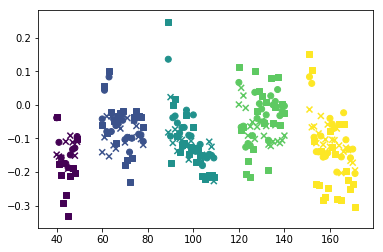

In [33]:
cols = sil_cd2_df.columns.values
x = [int(i[0])* 10 + n for n,i in enumerate(sil_cd2_df[cols].columns.values)]


plt.scatter(x,sil_red_df.mean()[cols].values, c = [int(i[0]) for i in sil_cd2_df[cols].columns.values], marker = 'x')
plt.scatter(x,sil_geo_df[cols].mean().values/3, c = [int(i[0]) for i in sil_cd2_df[cols].columns.values], marker='o')
plt.scatter(x,sil_cd4_df.mean()[cols].values, c = [int(i[0]) for i in sil_cd2_df[cols].columns.values], marker='s')

In [265]:
geosom_number = np.array([int(i[0]) if i[-1] is not '_' else 0 for i in preds_full.columns.values])
kmeans_number = np.array([int(i[2:]) if (i[-1] is not '_') & (len(i) > 1) else (0 if len(i)==1 else int(i[:-1])) for i in preds_full.columns.values])

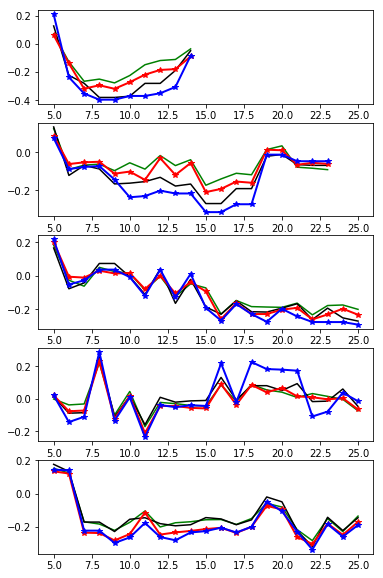

In [341]:
fig, ax = plt.subplots(5)
fig.set_size_inches(6, 10)

for n,g in enumerate(np.unique(geosom_number)):
    
    ind = geosom_number == g
    cols = preds_full.columns.values[ind]
    
#     ax[n].plot(kmeans_number[ind], sil_red_df.loc[:,cols].mean() * 4, 'k-')
    ax[n].plot(kmeans_number[ind], sil_cd3_df.loc[:,cols].mean(), 'g-')
    ax[n].plot(kmeans_number[ind], sil_cd3_df.loc[:,cols].median(), 'k-')
    ax[n].plot(kmeans_number[ind], sil_cd4_df.loc[:,cols].mean(), 'r*-', lw = 2)
    ax[n].plot(kmeans_number[ind], sil_cd4_df.loc[:,cols].median(), 'b*-', lw = 2)
    
#     ax[n].plot(kmeans_number[ind], landscape_metrics.loc['nIJI',cols], 'b*-', lw = 2)
#     ax[n].plot(kmeans_number[ind], landscape_metrics.loc['nC',cols], 'm*-', lw = 2)
#     ax[n].plot(kmeans_number[ind], landscape_metrics.loc['C',cols] * landscape_metrics.loc['IJI',cols], 'k*-', lw = 2)
    
    
    ax[n].set_xlim(4,26)
#     ax[n].set_ylim(-0.7, 0.3)

In [346]:
sort = np.argsort(sil_cd4_df.median().values)[::-1]

print sil_cd4_df.columns.values[sort]

['7_8' '7_18' '6_5' '7_16' '4_5' '7_19' '7_20' '7_21' '8_5' '8_6' '5_5'
 '7_24' '6_12' '6_9' '6_8' '7_5' '6_14' '7_10' '6_10' '5_20' '5_19' '7_25'
 '7_17' '6_7' '7_12' '7_14' '7_15' '5_23' '5_22' '5_21' '8_19' '7_13' '6_6'
 '5_8' '5_7' '7_23' '4_14' '5_6' '8_20' '7_22' '7_7' '6_11' '6_13' '7_9'
 '7_6' '5_9' '6_17' '8_11' '8_23' '8_25' '6_15' '6_20' '8_18' '5_12' '8_16'
 '5_13' '5_14' '8_7' '8_8' '8_15' '8_21' '6_18' '5_11' '8_17' '8_14' '7_11'
 '4_6' '5_10' '6_21' '8_24' '8_12' '8_10' '6_16' '6_19' '5_17' '5_18'
 '6_22' '6_24' '6_23' '8_13' '6_25' '8_9' '4_13' '5_16' '5_15' '8_22'
 '4_12' '4_7' '4_11' '4_10' '4_9' '4_8']


In [212]:
import fiona
import geopandas as gpd

shp = gpd.read_file('ganges_metrics/metrics_geosom_all/geoSom/kmeans_all.shp')

c = fiona.open('ganges_metrics/network.shp')
network_lines = MultiLineString([shape(pol['geometry']) for pol in c])
c = None

bounds = pickle.load( open( 'ganges_metrics/island_boundary_channels.p', "rb" ) )

In [314]:
landscape_metrics = pd.DataFrame(columns = preds_full.columns)

'''
IJI equals minus the sum of the length (m) of each unique edge type divided
by the total landscape edge (m), multiplied by the logarithm of the same quantity,
summed over each unique edge type; divided by the logarithm of the number of patch
types times the number of patch types minus 1 divided by 2; multiplied by 100
(to convert to a percentage). In other words, the observed interspersion over
the maximum possible interspersion for the given number of patch types.
Note, IJI considers all patch types present on an image, including any present
in the landscape border, if present. All background edge segments are ignored,
as are landscape boundary segments if a border is not provided, because adjacency
information for these edge segments is not available and the intermixing of classes
with background is assumed to be irrelevant.

IJI approaches 0 when the distribution of adjacencies among unique patch types
becomes increasingly uneven. IJI = 100 when all patch types are equally adjacent
to all other patch types (i.e., maximum interspersion and juxtaposition).

Interspersion and juxtaposition index is based on patch adjacencies, not cell
adjacencies like the contagion index. As such, it does not provide a measure
of class aggregation like the contagion index, but rather isolates the
interspersion or intermixing of patch types.
'''

cellsize = 30

connectivity = pd.DataFrame(columns = ['cohesion'])

bounds_cumsum = np.cumsum([len(i) for i in bounds])
bounds_index = np.arange(len(bounds))
flat_bounds = np.array([i for sublist in bounds for i in sublist])

tot_length = sum([network_lines[i].length / cellsize for i in np.unique(flat_bounds)])

for col in preds_full.columns:

    classes = preds_full[col]
    class_edge_sum = np.zeros(len(np.unique(classes)))
    
    cohesion_vals = []

    for class_num in np.unique(classes):
        
        class_name = col + '_' + str(class_num)

        isls = np.where(shp[col] == class_num)[0]

        edge_length_by_class = np.zeros(len(np.unique(classes)))
        
        perim = []

        for isl in isls:

            b = bounds[isl]
            
            perim_ = 0

            for line in b:

                n_line = np.where(flat_bounds == line)[0]

                neighbor = [np.where(bounds_cumsum > n)[0][0] for n in n_line if np.where(bounds_cumsum > n)[0][0] != isl]

                if len(neighbor) > 0:

                    class_neighbor = classes[neighbor[0]]

                    edge_length_by_class[class_neighbor] += network_lines[line].length / cellsize
                    
                    if class_neighbor != class_num:
                        perim_ += network_lines[line].length / cellsize
                        
            perim.append(perim_)
            

        class_edge_sum[class_num] = np.nansum((edge_length_by_class / tot_length) * np.log10(edge_length_by_class / tot_length))


        areas = np.array([i.area / cellsize / cellsize for i in shp.loc[shp[col] == class_num]['geometry'].tolist()])

        cohesion = (1 - (np.sum(perim) / np.sum(perim * np.sqrt(areas)))) / (1 - (1 / np.sqrt(islands.area / cellsize / cellsize))) * 100
        connectivity.loc[0, class_name] = cohesion
        cohesion_vals.append(cohesion)
        
    m = np.max(np.unique(classes))
    landscape_metrics.loc['IJI',col] = -np.nansum(class_edge_sum) / np.log10(0.5 * (m * (m - 1))) * 100
    landscape_metrics.loc['cohesion',col] = np.mean(cohesion_vals)

/Users/mari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: RuntimeWarning: divide by zero encountered in log10
/Users/mari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in multiply


In [306]:
pd.to_pickle(landscape_metrics, '../pubs/landcape_metrics.p')
pd.to_pickle(connectivity, '../pubs/connectivity.p')

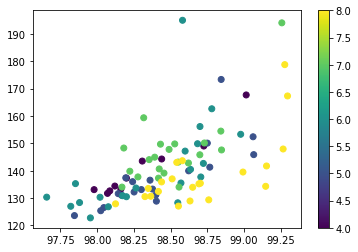

In [315]:
plt.scatter(landscape_metrics.loc['cohesion'].values.T, landscape_metrics.loc['IJI'].values.T,
           c = [int(i[0]) for i in preds_full.columns.values])
plt.colorbar()

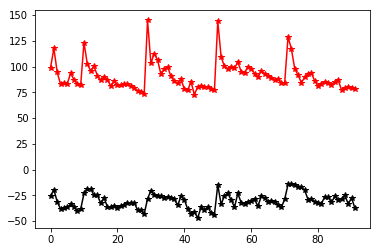

In [330]:
plt.plot(landscape_metrics.loc['cohesion'].values.T * 20 - 2000, 'k*-')
plt.plot(landscape_metrics.loc['IJI'].values.T - 50, 'r*-')

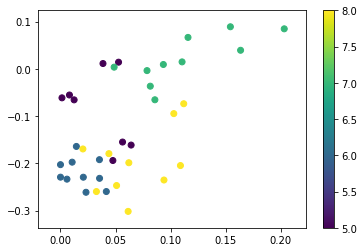

In [333]:
landscape_metrics.loc['nIJI'] = (landscape_metrics.loc['IJI'] - landscape_metrics.loc['IJI'].min()) / (landscape_metrics.loc['IJI'].max() - landscape_metrics.loc['IJI'].min())
landscape_metrics.loc['nC'] = (landscape_metrics.loc['cohesion'] - landscape_metrics.loc['cohesion'].min()) / (landscape_metrics.loc['cohesion'].max() - landscape_metrics.loc['cohesion'].min())

# cols = preds_full.columns
# plt.scatter(landscape_metrics.loc['nIJI'][cols].values.T * landscape_metrics.loc['nC'][cols].values.T,
#             sil_cd4_df.mean()[cols].values,
#            c = [int(i[0]) for i in cols], marker = 'x')


cols = [i for i in preds_full.columns if int(i[2:]) > 15]
plt.scatter(landscape_metrics.loc['nIJI'][cols].values.T * landscape_metrics.loc['nC'][cols].values.T,
            sil_cd4_df.mean()[cols].values,
           c = [int(i[0]) for i in cols])


plt.colorbar()

In [288]:
landscape_metrics.loc['cohesion'].max()

99.976582734288471

In [2684]:
fields = pd.DataFrame()
# fields['all'] = new_class
# fields['8_19'] = preds_full['8_19']
# fields['6_17'] = preds_full['6_17']
# fields['count'] = count_new_class_all
# fields['t_10'] = new_class_thresh_10
# fields['t_20'] = new_class_thresh_20
fields[col] = preds_full[col]
fields['sil'] = silhoutte_samples
fields['g_sil'] = geo_silhoutte_samples
fields['dist_c'] = dist_from_centroid
fields['med_dist'] = med_dist_med
fields['avg'] = avg_scores.values.mean(axis=1)

fields['cd2'] = sil_cd2_df[col]
fields['raw'] = sil_raw_df[col]
fields['red'] = sil_red_df[col]
fields['geo'] = sil_geo_df[col]
fields['cd3'] = sil_cd3_df[col]
fields['cd4'] = sil_cd4_df[col]

field_type = {}

for k in fields.columns:
    field_type[k] = ogr.OFTReal
    

create_shapefile_from_shapely_multi(islands,
                                    '../pubs/intersect_8_19__6_17.shp',
                                    fields = fields,
                                    field_type = field_type)

In [322]:
# vals = pd.crosstab(preds_full['8_19'],preds_full['6_17']).values

# rows = np.sum(vals > 0, axis = 1)
# cols = np.sum(vals > 0, axis = 0)

# pairs_1_1 = [(n,np.where(vals[n,:] > 0)[0][0]) for n,r in enumerate(rows) if (r == 1) & (cols[np.where(vals[n,:] > 0)[0][0]] == 1)]
# sort = np.argsort([vals[i] for i in pairs_1_1])[::-1]

# new_row_order = list(np.array([r[0] for r in pairs_1_1])[sort])
# new_col_order = list(np.array([r[1] for r in pairs_1_1])[sort])

# new_row_order += [r for r in range(vals.shape[0]) if r not in new_row_order]
# new_col_order +=  [r for r in range(vals.shape[1]) if r not in new_col_order]

# flows = pd.DataFrame()

# thresh = 5
# flows['source'] = np.where(vals > thresh)[0]
# flows['target'] = np.where(vals > thresh)[1]
# flows['value'] = vals[vals > thresh]
# flows['color'] = np.log2(vals[vals > thresh])

# row, col = np.where(vals > thresh)

# count = vals[vals > thresh]
# sort = np.argsort(count)[::-1]

# row = list(row[sort])
# col = list(col[sort])

# sorter = pd.DataFrame()
# sorter['rows'] = row
# sorter['cols'] = col
# sorter['count'] = count[sort]

# unique_rows = sorter.rows[~sorter.duplicated('rows',keep='first')].tolist()
# unique_cols = sorter.cols[~sorter.duplicated('cols',keep='first')].tolist()

# from floweaver import *
# import pandas as pd
# from io import StringIO

# # Set the default size to fit the documentation better.
# size = dict(width=650, height=1000)


# nodes = {
#     'source': ProcessGroup(list(np.where(vals > 0)[0])),
#     'target': ProcessGroup(list(np.where(vals > 0)[1])),
# }

# bundles = [
#     Bundle('source', 'target'),
# ]

# ordering = [
#     ['source'],
#     ['target'],
# ]


# # unique_rows = [0, 11, 14, 5, 2, 6, 8, 15, 9, 7, 12, 18, 10,   13, 3, 4]
# # unique_cols = [12, 7, 11, 16, 1, 6, 0, 2, 8, 15, 14, 5, 4, 3, ]

# unique_rows = [ 4, 13, 1,3,12,18,10, 9,17,11,7,0, 14,6,16,15, 8,2,5]
# unique_cols = [ 3,4, 13,5,15, 8,7,14,9,12, 11,16,   2,0,10,6,1]

# source_partition = Partition.Simple('process',unique_rows)
# target_partition = Partition.Simple('process',unique_cols)

# nodes['source'].partition = source_partition
# nodes['target'].partition = target_partition


# sdd = SankeyDefinition(nodes, bundles, ordering)

# weave(sdd, flows,  measures={'value':'sum', 'color': 'sum'},
#       link_width= 'value',
#       link_color = QuantitativeScale('color', palette='YlGnBu_5')).to_widget(**size)



SankeyWidget(groups=[{'nodes': ['source^4', 'source^13', 'source^1', 'source^3', 'source^12', 'source^18', 'source^10', 'source^9', 'source^17', 'source^11', 'source^7', 'source^0', 'source^14', 'source^6', 'source^16', 'source^15', 'source^8', 'source^2', 'source^5'], 'type': 'process', 'id': 'source', 'title': ''}, {'nodes': ['target^3', 'target^4', 'target^13', 'target^5', 'target^15', 'target^8', 'target^7', 'target^14', 'target^12', 'target^11', 'target^16', 'target^2', 'target^0', 'target^6', 'target^1'], 'type': 'process', 'id': 'target', 'title': ''}], layout=Layout(height=u'1000', width=u'650'), links=[{'opacity': 1.0, 'source': 'source^9', 'target': 'target^15', 'time': '*', 'color': '#a5dcb5', 'title': '*', 'type': '*', 'value': 12.0}, {'opacity': 1.0, 'source': 'source^9', 'target': 'target^5', 'time': '*', 'color': '#7fcdba', 'title': '*', 'type': '*', 'value': 16.0}, {'opacity': 1.0, 'source': 'source^9', 'target': 'target^6', 'time': '*', 'color': '#ffffcc', 'title': '*', 'type': '*', 'value': 6.0}, {'opacity': 1.0, 'source': 'source^9', 'target': 'target^8', 'time': '*', 'color': '#9bd8b5', 'title': '*', 'type': '*', 'value': 13.0}, {'opacity': 1.0, 'source': 'source^9', 'target': 'target^2', 'time': '*', 'color': '#b1e0b8', 'title': '*', 'type': '*', 'value': 11.0}, {'opacity': 1.0, 'source': 'source^8', 'target': 'target^6', 'time': '*', 'color': '#4fbbc2', 'title': '*', 'type': '*', 'value': 23.0}, {'opacity': 1.0, 'source': 'source^1', 'target': 'target^13', 'time': '*', 'color': '#ecf7c7', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': 'source^0', 'target': 'target^14', 'time': '*', 'color': '#ecf7c7', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': 'source^0', 'target': 'target^7', 'time': '*', 'color': '#45b7c3', 'title': '*', 'type': '*', 'value': 25.0}, {'opacity': 1.0, 'source': 'source^0', 'target': 'target^11', 'time': '*', 'color': '#b1e0b8', 'title': '*', 'type': '*', 'value': 11.0}, {'opacity': 1.0, 'source': 'source^0', 'target': 'target^12', 'time': '*', 'color': '#253494', 'title': '*', 'type': '*', 'value': 110.0}, {'opacity': 1.0, 'source': 'source^3', 'target': 'target^4', 'time': '*', 'color': '#92d4b7', 'title': '*', 'type': '*', 'value': 14.0}, {'opacity': 1.0, 'source': 'source^3', 'target': 'target^7', 'time': '*', 'color': '#ffffcc', 'title': '*', 'type': '*', 'value': 6.0}, {'opacity': 1.0, 'source': 'source^2', 'target': 'target^6', 'time': '*', 'color': '#2b72b2', 'title': '*', 'type': '*', 'value': 60.0}, {'opacity': 1.0, 'source': 'source^2', 'target': 'target^1', 'time': '*', 'color': '#89d1b8', 'title': '*', 'type': '*', 'value': 15.0}, {'opacity': 1.0, 'source': 'source^2', 'target': 'target^2', 'time': '*', 'color': '#ffffcc', 'title': '*', 'type': '*', 'value': 6.0}, {'opacity': 1.0, 'source': 'source^5', 'target': 'target^11', 'time': '*', 'color': '#a5dcb5', 'title': '*', 'type': '*', 'value': 12.0}, {'opacity': 1.0, 'source': 'source^5', 'target': 'target^16', 'time': '*', 'color': '#ecf7c7', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': 'source^5', 'target': 'target^1', 'time': '*', 'color': '#295ca7', 'title': '*', 'type': '*', 'value': 74.0}, {'opacity': 1.0, 'source': 'source^5', 'target': 'target^6', 'time': '*', 'color': '#78cbbb', 'title': '*', 'type': '*', 'value': 17.0}, {'opacity': 1.0, 'source': 'source^4', 'target': 'target^4', 'time': '*', 'color': '#2c80b8', 'title': '*', 'type': '*', 'value': 52.0}, {'opacity': 1.0, 'source': 'source^4', 'target': 'target^3', 'time': '*', 'color': '#284fa1', 'title': '*', 'type': '*', 'value': 84.0}, {'opacity': 1.0, 'source': 'source^7', 'target': 'target^15', 'time': '*', 'color': '#70c8bc', 'title': '*', 'type': '*', 'value': 18.0}, {'opacity': 1.0, 'source': 'source^7', 'target': 'target^14', 'time': '*', 'color': '#39a1bf', 'title': '*', 'type': '*', 'value': 34.0}, {'opacity': 1.0, 'source': 'source^7', 'target': 'target^7', 'time': '*', 'color': '#ecf7

In [810]:
# flows = pd.DataFrame()
# processes = pd.DataFrame()

# thresh = 0

# source_i = []
# target_i = []
# value = []
# color = []
# node_type = []

# unique_rows = {}


# for i in range(10,20):
    
#     vals = pd.crosstab(preds_full['8_' + str(i)],preds_full['8_' + str(i+1)]).values

#     source_i += [str(i) + '_' + str(l) for l in list(np.where(vals > thresh)[0])]
#     target_i += [str(i+1) + '_' + str(l) for l in list(np.where(vals > thresh)[1])]
#     value += list(vals[vals > thresh])
#     color += list(np.log10(vals[vals > thresh]))
#     node_type += [(str(i), str(i) + '_' + str(l)) for l in set(np.where(vals > thresh)[0])]
    
    
#     row, col = np.where(vals > 0)

#     count = vals[vals > 0]
#     sort = np.argsort(count)[::-1]

#     row = list(row[sort])

#     sorter = pd.DataFrame()
#     sorter['rows'] = row

#     unique_rows[str(i)] = [str(i) + '_' + str(l) for l in sorter.rows[~sorter.duplicated('rows',keep='first')].tolist()]


# row, col = np.where(vals > 0)

# count = vals[vals > 0]
# sort = np.argsort(count)[::-1]

# col = list(col[sort])

# sorter = pd.DataFrame()
# sorter['rows'] = row
# sorter['cols'] = col

# unique_rows[str(i+1)] = [str(i+1) + '_' + str(l) for l in sorter.cols[~sorter.duplicated('cols',keep='first')].tolist()]
    
# node_type += [(str(i+1), str(i+1) + '_' + str(l)) for l in set(np.where(vals > thresh)[1])] 

# flows['source'] = source_i
# flows['target'] = target_i
# flows['value'] = value
# flows['color'] = color


# # Set the default size to fit the documentation better.
# size = dict(width=1100, height=500)



# processes = pd.DataFrame(data = np.array(node_type)[:,0], index = np.array(node_type)[:,1], columns=['type'])

# dataset = Dataset(flows, dim_process=processes)

# nodes = {
#     '10': ProcessGroup('type == "10"'),
#     '11': ProcessGroup('type == "11"'),
#     '12': ProcessGroup('type == "12"'),
#     '13': ProcessGroup('type == "13"'),
#     '14': ProcessGroup('type == "14"'),
#     '15': ProcessGroup('type == "15"'),
#     '16': ProcessGroup('type == "16"'),
#     '17': ProcessGroup('type == "17"'),
#     '18': ProcessGroup('type == "18"'),
#     '19': ProcessGroup('type == "19"'),
#     '20': ProcessGroup('type == "20"'),
# }

# ordering = [[str(i)] for i in range(10,21,1)]
    
# bundles = [
#     Bundle('10','11'),
#     Bundle('11','12'),
#     Bundle('12','13'),
#     Bundle('13','14'),
#     Bundle('14','15'),
#     Bundle('15','16'),
#     Bundle('16','17'),
#     Bundle('17','18'),
#     Bundle('18','19'),
#     Bundle('19','20'),
# ]

In [811]:
# unique_rows['10'] = [ '10_4', '10_7', '10_6', '10_0', '10_2', '10_3','10_9', '10_5', '10_8', '10_1',]

# unique_rows['11'] = ['11_10', '11_6', '11_8', '11_0', '11_9', '11_5', '11_1', '11_7', '11_4', '11_3', '11_2',]

# unique_rows['12'] = ['12_7','12_1', '12_8', '12_11', '12_6', '12_10', '12_2', '12_4', '12_9', '12_5', '12_0', '12_3',]

# unique_rows['13'] = ['13_4','13_0', '13_7', '13_12', '13_5', '13_3', '13_8', '13_11', '13_6', '13_1', '13_9', '13_10', '13_2']

# unique_rows['14'] = ['14_0', '14_8', '14_13', '14_3', '14_11', '14_5', '14_12', '14_4', '14_2', '14_1', '14_9', '14_6', '14_10', '14_7',]

# unique_rows['15'] = [ '15_3', '15_2', '15_14', '15_1', '15_5', '15_13', '15_9', '15_10', '15_6', '15_4', '15_8', '15_0', '15_11', '15_7', '15_12',]

# unique_rows['16'] = ['16_4', '16_5', '16_9', '16_13', '16_6', '16_3', '16_15', '16_10', '16_1', '16_11', '16_14', '16_8', '16_0', '16_7', '16_2', '16_12',] 

# unique_rows['17'] = ['17_5', '17_2', '17_14', '17_1', '17_9', '17_4', '17_13', '17_16', '17_10', '17_15', '17_0', '17_12', '17_8', '17_7', '17_6', '17_3', '17_11',] 

# unique_rows['18'] = ['18_3', '18_6', '18_15', '18_4', '18_17', '18_10', '18_1', '18_7', '18_12', '18_14', '18_5', '18_13', '18_11', '18_16', '18_9', '18_0', '18_2', '18_8',] 

# unique_rows['19'] = ['19_5', '19_2', '19_6', '19_7', '19_13', '19_18', '19_1', '19_15','19_8', '19_16', '19_10', '19_17', '19_9', '19_12', '19_11', '19_0', '19_14', '19_4', '19_3', ] 

# unique_rows['20'] = ['20_5', '20_11', '20_2', '20_16', '20_6', '20_12', '20_0', '20_4', '20_14', '20_10', '20_15', '20_19', '20_9', '20_1', '20_7', '20_8', '20_18', '20_13', '20_3', '20_17',]

In [814]:
# for n,i in enumerate(range(10,21,1)):
    
#     by_class = Partition.Simple('process', unique_rows[str(i)])
#     nodes[str(i)].partition = by_class

# sdd = SankeyDefinition(nodes, bundles, ordering)
# weave(sdd, dataset,
#       measures={'value':'sum', 'color': 'sum'},
#       link_width= 'value',
#       link_color = QuantitativeScale('color', palette='YlGnBu_5')
#      ).to_widget(**size).auto_save_svg('../pubs/sankey_8.svg')

SankeyWidget(groups=[{'nodes': ['10^10_4', '10^10_7', '10^10_6', '10^10_0', '10^10_2', '10^10_3', '10^10_9', '10^10_5', '10^10_8', '10^10_1'], 'type': 'process', 'id': '10', 'title': ''}, {'nodes': ['11^11_10', '11^11_6', '11^11_8', '11^11_0', '11^11_9', '11^11_5', '11^11_1', '11^11_7', '11^11_4', '11^11_3', '11^11_2'], 'type': 'process', 'id': '11', 'title': ''}, {'nodes': ['12^12_7', '12^12_1', '12^12_8', '12^12_11', '12^12_6', '12^12_10', '12^12_2', '12^12_4', '12^12_9', '12^12_5', '12^12_0', '12^12_3'], 'type': 'process', 'id': '12', 'title': ''}, {'nodes': ['13^13_4', '13^13_0', '13^13_7', '13^13_12', '13^13_5', '13^13_3', '13^13_8', '13^13_11', '13^13_6', '13^13_1', '13^13_9', '13^13_10', '13^13_2'], 'type': 'process', 'id': '13', 'title': ''}, {'nodes': ['14^14_0', '14^14_8', '14^14_13', '14^14_3', '14^14_11', '14^14_5', '14^14_12', '14^14_4', '14^14_2', '14^14_1', '14^14_9', '14^14_6', '14^14_10', '14^14_7'], 'type': 'process', 'id': '14', 'title': ''}, {'nodes': ['15^15_3', '15^15_2', '15^15_14', '15^15_1', '15^15_5', '15^15_13', '15^15_9', '15^15_10', '15^15_6', '15^15_4', '15^15_8', '15^15_0', '15^15_11', '15^15_7', '15^15_12'], 'type': 'process', 'id': '15', 'title': ''}, {'nodes': ['16^16_4', '16^16_5', '16^16_9', '16^16_13', '16^16_6', '16^16_3', '16^16_15', '16^16_10', '16^16_1', '16^16_11', '16^16_14', '16^16_8', '16^16_0', '16^16_7', '16^16_2', '16^16_12'], 'type': 'process', 'id': '16', 'title': ''}, {'nodes': ['17^17_5', '17^17_2', '17^17_14', '17^17_1', '17^17_9', '17^17_4', '17^17_13', '17^17_16', '17^17_10', '17^17_15', '17^17_0', '17^17_12', '17^17_8', '17^17_7', '17^17_6', '17^17_3', '17^17_11'], 'type': 'process', 'id': '17', 'title': ''}, {'nodes': ['18^18_3', '18^18_6', '18^18_15', '18^18_4', '18^18_17', '18^18_10', '18^18_1', '18^18_7', '18^18_12', '18^18_14', '18^18_5', '18^18_13', '18^18_11', '18^18_16', '18^18_9', '18^18_0', '18^18_2', '18^18_8'], 'type': 'process', 'id': '18', 'title': ''}, {'nodes': ['19^19_5', '19^19_2', '19^19_6', '19^19_7', '19^19_13', '19^19_18', '19^19_1', '19^19_15', '19^19_8', '19^19_16', '19^19_10', '19^19_17', '19^19_9', '19^19_12', '19^19_11', '19^19_0', '19^19_14', '19^19_4', '19^19_3'], 'type': 'process', 'id': '19', 'title': ''}, {'nodes': ['20^20_5', '20^20_11', '20^20_2', '20^20_16', '20^20_6', '20^20_12', '20^20_0', '20^20_4', '20^20_14', '20^20_10', '20^20_15', '20^20_19', '20^20_9', '20^20_1', '20^20_7', '20^20_8', '20^20_18', '20^20_13', '20^20_3', '20^20_17'], 'type': 'process', 'id': '20', 'title': ''}], layout=Layout(height=u'500', width=u'1100'), links=[{'opacity': 1.0, 'source': '16^16_11', 'target': '17^17_0', 'time': '*', 'color': '#87d0b8', 'title': '*', 'type': '*', 'value': 9.0}, {'opacity': 1.0, 'source': '14^14_2', 'target': '15^15_10', 'time': '*', 'color': '#2b78b5', 'title': '*', 'type': '*', 'value': 77.0}, {'opacity': 1.0, 'source': '15^15_4', 'target': '16^16_8', 'time': '*', 'color': '#379bbe', 'title': '*', 'type': '*', 'value': 38.0}, {'opacity': 1.0, 'source': '15^15_5', 'target': '16^16_15', 'time': '*', 'color': '#3ca8c1', 'title': '*', 'type': '*', 'value': 29.0}, {'opacity': 1.0, 'source': '15^15_5', 'target': '16^16_3', 'time': '*', 'color': '#2d83b9', 'title': '*', 'type': '*', 'value': 63.0}, {'opacity': 1.0, 'source': '15^15_6', 'target': '16^16_14', 'time': '*', 'color': '#2b75b3', 'title': '*', 'type': '*', 'value': 81.0}, {'opacity': 1.0, 'source': '15^15_6', 'target': '16^16_11', 'time': '*', 'color': '#87d0b8', 'title': '*', 'type': '*', 'value': 9.0}, {'opacity': 1.0, 'source': '15^15_7', 'target': '16^16_2', 'time': '*', 'color': '#284fa1', 'title': '*', 'type': '*', 'value': 147.0}, {'opacity': 1.0, 'source': '15^15_0', 'target': '16^16_7', 'time': '*', 'color': '#3ca9c1', 'title': '*', 'type': '*', 'value': 28.0}, {'opacity': 1.0, 'source': '15^15_1', 'target': '16^16_6', 'time': '*', 'color': '#295aa6', 'title': '*', 'type': '*', 'value': 124.0}, {'opacity': 1.0, 'source': '15^15_1', 'target': '16^16_13', 'time': '*', '

In [1575]:
# flows = pd.DataFrame()
# processes = pd.DataFrame()

# thresh = 0

# source_i = []
# target_i = []
# value = []
# color = []
# node_type = []

# # unique_rows = {}


# for i in range(4,8):
    
#     vals = pd.crosstab(regions_all[str(i)],regions_all[str(i+1)]).values

#     source_i += [str(i) + '_' + str(l) for l in list(np.where(vals > thresh)[0])]
#     target_i += [str(i+1) + '_' + str(l) for l in list(np.where(vals > thresh)[1])]
#     value += list(vals[vals > thresh])
#     color += list(np.log10(vals[vals > thresh]))
#     node_type += [(str(i), str(i) + '_' + str(l)) for l in set(np.where(vals > thresh)[0])]
    

# node_type += [(str(i+1), str(i+1) + '_' + str(l)) for l in set(np.where(vals > thresh)[1])] 

# flows['source'] = source_i
# flows['target'] = target_i
# flows['value'] = value
# flows['color'] = color


# # Set the default size to fit the documentation better.
# size = dict(width=800, height=1000)



# processes = pd.DataFrame(data = np.array(node_type)[:,0], index = np.array(node_type)[:,1], columns=['type'])

# dataset = Dataset(flows, dim_process=processes)

# nodes = {
#     '4': ProcessGroup('type == "4"'),
#     '5': ProcessGroup('type == "5"'),
#     '6': ProcessGroup('type == "6"'),
#     '7': ProcessGroup('type == "7"'),
#     '8': ProcessGroup('type == "8"'),
# }

# ordering = [[str(i)] for i in range(4,9)]
    
# bundles = [
#     Bundle('4','5'),
#     Bundle('5','6'),
#     Bundle('6','7'),
#     Bundle('7','8'),
# ]

In [1581]:
# unique_rows['4'] = ['4_11', '4_12', '4_7', '4_8', '4_13', '4_9', '4_14', '4_10', '4_5', '4_6', '4_4', '4_3','4_0', '4_2', '4_1',] 

# unique_rows['5'] = ['5_21', '5_20', '5_19','5_16', '5_15', '5_11', '5_14', '5_22', '5_17', '5_6', '5_23','5_7','5_3', '5_12', '5_18', '5_13', '5_8', '5_9', '5_10', '5_5', '5_2','5_1', '5_4', '5_0', ] 

# unique_rows['6'] = ['6_32', '6_31', '6_30', '6_29', '6_26', '6_25', '6_24', '6_20', '6_19', '6_23', '6_33', '6_27','6_8','6_14','6_7', '6_34','6_3', '6_4','6_15', '6_9', '6_21', '6_28', '6_22', '6_16', '6_10', '6_17','6_13', '6_18', '6_12', '6_6','6_2','6_1', '6_11', '6_5', '6_0', ] 

# unique_rows['7'] = ['7_42','7_41', '7_40', '7_39', '7_38', '7_14', '7_13','7_12', '7_20', '7_34','7_33', '7_35', '7_8','7_21', '7_32', '7_27', '7_19', '7_31', '7_43', '7_28', '7_7', '7_9', '7_11', '7_6','7_44', '7_29', '7_36','7_37','7_22','7_15', '7_30', '7_23','7_16', '7_24', '7_25','7_18', '7_26', '7_5', '7_3', '7_2', '7_1', '7_17','7_4','7_10', '7_0',] 

# unique_rows['8'] = ['8_55','8_54', '8_53', '8_52', '8_51', '8_50', '8_23','8_22', '8_21', '8_20', '8_29', '8_30', '8_45', '8_44','8_46','8_47', '8_15', '8_31', '8_43','8_38', '8_37', '8_28', '8_42', '8_56', '8_24', '8_39', '8_13', '8_16', '8_9', '8_19', '8_8', '8_12','8_57','8_25','8_48','8_32', '8_40', '8_49', '8_41', '8_33', '8_34', '8_35','8_27', '8_36','8_2','8_1', '8_11', '8_7', '8_3','8_6', '8_0', '8_26', '8_5', '8_10', '8_18', '8_14', '8_17', '8_4',]

In [1584]:
# for n,i in enumerate(range(4,9)):
    
#     by_class = Partition.Simple('process', unique_rows[str(i)])
#     nodes[str(i)].partition = by_class

# sdd = SankeyDefinition(nodes, bundles, ordering)
# weave(sdd, dataset,
#       measures={'value':'sum', 'color': 'sum'},
#       link_width= 'value',
#       link_color = QuantitativeScale('color', palette='YlOrBr_9')
#      ).to_widget(**size).auto_save_svg('../pubs/sankey_geosom.svg')

SankeyWidget(groups=[{'nodes': ['4^4_11', '4^4_12', '4^4_7', '4^4_8', '4^4_13', '4^4_9', '4^4_14', '4^4_10', '4^4_5', '4^4_6', '4^4_4', '4^4_3', '4^4_0', '4^4_2', '4^4_1'], 'type': 'process', 'id': '4', 'title': ''}, {'nodes': ['5^5_21', '5^5_20', '5^5_19', '5^5_16', '5^5_15', '5^5_11', '5^5_14', '5^5_22', '5^5_17', '5^5_6', '5^5_23', '5^5_7', '5^5_3', '5^5_12', '5^5_18', '5^5_13', '5^5_8', '5^5_9', '5^5_10', '5^5_5', '5^5_2', '5^5_1', '5^5_4', '5^5_0'], 'type': 'process', 'id': '5', 'title': ''}, {'nodes': ['6^6_32', '6^6_31', '6^6_30', '6^6_29', '6^6_26', '6^6_25', '6^6_24', '6^6_20', '6^6_19', '6^6_23', '6^6_33', '6^6_27', '6^6_8', '6^6_14', '6^6_7', '6^6_34', '6^6_3', '6^6_4', '6^6_15', '6^6_9', '6^6_21', '6^6_28', '6^6_22', '6^6_16', '6^6_10', '6^6_17', '6^6_13', '6^6_18', '6^6_12', '6^6_6', '6^6_2', '6^6_1', '6^6_11', '6^6_5', '6^6_0'], 'type': 'process', 'id': '6', 'title': ''}, {'nodes': ['7^7_42', '7^7_41', '7^7_40', '7^7_39', '7^7_38', '7^7_14', '7^7_13', '7^7_12', '7^7_20', '7^7_34', '7^7_33', '7^7_35', '7^7_8', '7^7_21', '7^7_32', '7^7_27', '7^7_19', '7^7_31', '7^7_43', '7^7_28', '7^7_7', '7^7_9', '7^7_11', '7^7_6', '7^7_44', '7^7_29', '7^7_36', '7^7_37', '7^7_22', '7^7_15', '7^7_30', '7^7_23', '7^7_16', '7^7_24', '7^7_25', '7^7_18', '7^7_26', '7^7_5', '7^7_3', '7^7_2', '7^7_1', '7^7_17', '7^7_4', '7^7_10', '7^7_0'], 'type': 'process', 'id': '7', 'title': ''}, {'nodes': ['8^8_55', '8^8_54', '8^8_53', '8^8_52', '8^8_51', '8^8_50', '8^8_23', '8^8_22', '8^8_21', '8^8_20', '8^8_29', '8^8_30', '8^8_45', '8^8_44', '8^8_46', '8^8_47', '8^8_15', '8^8_31', '8^8_43', '8^8_38', '8^8_37', '8^8_28', '8^8_42', '8^8_56', '8^8_24', '8^8_39', '8^8_13', '8^8_16', '8^8_9', '8^8_19', '8^8_8', '8^8_12', '8^8_57', '8^8_25', '8^8_48', '8^8_32', '8^8_40', '8^8_49', '8^8_41', '8^8_33', '8^8_34', '8^8_35', '8^8_27', '8^8_36', '8^8_2', '8^8_1', '8^8_11', '8^8_7', '8^8_3', '8^8_6', '8^8_0', '8^8_26', '8^8_5', '8^8_10', '8^8_18', '8^8_14', '8^8_17', '8^8_4'], 'type': 'process', 'id': '8', 'title': ''}], layout=Layout(height=u'1000', width=u'800'), links=[{'opacity': 1.0, 'source': '7^7_22', 'target': '8^8_7', 'time': '*', 'color': '#fff1ae', 'title': '*', 'type': '*', 'value': 2.0}, {'opacity': 1.0, 'source': '7^7_22', 'target': '8^8_40', 'time': '*', 'color': '#fece65', 'title': '*', 'type': '*', 'value': 4.0}, {'opacity': 1.0, 'source': '7^7_22', 'target': '8^8_8', 'time': '*', 'color': '#ffffe5', 'title': '*', 'type': '*', 'value': 1.0}, {'opacity': 1.0, 'source': '7^7_22', 'target': '8^8_32', 'time': '*', 'color': '#f68820', 'title': '*', 'type': '*', 'value': 10.0}, {'opacity': 1.0, 'source': '7^7_22', 'target': '8^8_33', 'time': '*', 'color': '#ffffe5', 'title': '*', 'type': '*', 'value': 1.0}, {'opacity': 1.0, 'source': '7^7_22', 'target': '8^8_31', 'time': '*', 'color': '#ffffe5', 'title': '*', 'type': '*', 'value': 1.0}, {'opacity': 1.0, 'source': '7^7_22', 'target': '8^8_39', 'time': '*', 'color': '#fece65', 'title': '*', 'type': '*', 'value': 4.0}, {'opacity': 1.0, 'source': '6^6_34', 'target': '7^7_44', 'time': '*', 'color': '#d15205', 'title': '*', 'type': '*', 'value': 21.0}, {'opacity': 1.0, 'source': '6^6_34', 'target': '7^7_36', 'time': '*', 'color': '#fec14c', 'title': '*', 'type': '*', 'value': 5.0}, {'opacity': 1.0, 'source': '6^6_34', 'target': '7^7_37', 'time': '*', 'color': '#fff1ae', 'title': '*', 'type': '*', 'value': 2.0}, {'opacity': 1.0, 'source': '6^6_32', 'target': '7^7_21', 'time': '*', 'color': '#ffffe5', 'title': '*', 'type': '*', 'value': 1.0}, {'opacity': 1.0, 'source': '6^6_32', 'target': '7^7_20', 'time': '*', 'color': '#feb23f', 'title': '*', 'type': '*', 'value': 6.0}, {'opacity': 1.0, 'source': '6^6_32', 'target': '7^7_43', 'time': '*', 'color': '#ffffe5', 'title': '*', 'type': '*', 'value': 1.0}, {'opacity': 1.0, 'source': '6^6_32', 'target': '7^7_42', 'time': '*', 'color': '#c04602', 'title': '*', 'type': '*', 'value': 26.0}, {'opacity': 1.0, 'source': '6^6_32', 'target': '7^7_41', 'time': '*', 'color'

In [1666]:
# flows = pd.DataFrame()
# processes = pd.DataFrame()

# thresh = 1

# source_i = []
# target_i = []
# value = []
# color = []
# node_type = []

# # unique_rows = {}
   
# vals = pd.crosstab(preds_full['8_19'],preds_full['6_17']).values

# source_i += [str(8) + '_' + str(l) for l in list(np.where(vals > thresh)[0])]
# target_i += [str(6) + '_' + str(l) for l in list(np.where(vals > thresh)[1])]
# value += list(vals[vals > thresh])
# color += list(np.log10(vals[vals > thresh]))
# node_type += [(str(8), str(8) + '_' + str(l)) for l in set(np.where(vals > thresh)[0])]


# row, col = np.where(vals > 0)

# count = vals[vals > 0]
# sort = np.argsort(count)[::-1]

# row = list(row[sort])

# sorter = pd.DataFrame()
# sorter['rows'] = row

# unique_rows['8'] = [str(8) + '_' + str(l) for l in sorter.rows[~sorter.duplicated('rows',keep='first')].tolist()]

# col = list(col[sort])
# sorter['cols'] = col
# unique_rows['6'] = [str(6) + '_' + str(l) for l in sorter.cols[~sorter.duplicated('cols',keep='first')].tolist()]
    


# node_type += [(str(6), str(6) + '_' + str(l)) for l in set(np.where(vals > thresh)[1])] 

# flows['source'] = source_i
# flows['target'] = target_i
# flows['value'] = value
# flows['color'] = color


# # Set the default size to fit the documentation better.
# size = dict(width=800, height=1000)



# processes = pd.DataFrame(data = np.array(node_type)[:,0], index = np.array(node_type)[:,1], columns=['type'])

# dataset = Dataset(flows, dim_process=processes)

# nodes = {
#     '6': ProcessGroup('type == "6"'),
#     '8': ProcessGroup('type == "8"'),
# }

# ordering = [['8'],['6']]
    
# bundles = [
#     Bundle('8','6'),
# ]

  
# index = {}

# for r in np.unique(preds_full['8_19']):

#     index[r] = np.where(vals[r,:] == np.max(vals[r,:]))[0][0]

# used_indices = []


# valid_indices = range(np.max(preds_full['6_17']+1))
# counter = 0
# for r in [int(j[2:]) for j in unique_rows['8']]:
#     j = index[r]
#     k = j



#     try:
#         while (k in used_indices):
#             counter += 1
#             k = valid_indices[counter]

#         used_indices += [k]
#     except:
#         pass



# used_indices += [j for j in range(preds_full['6_17'].max()) if j not in used_indices] 

# sort = [int(j[2:]) for j in unique_rows['8']]

# unique_rows['6'] = ['6' + '_' + str(j) for j in used_indices]

# unique_rows['6'] = [
 

#  '6_1',


#  '6_9',
#  '6_10',


#  '6_6',  '6_0', '6_2', '6_16','6_11','6_8',

#  '6_5', '6_13', '6_3','6_4','6_15','6_14','6_12','6_7',]

# unique_rows['8'] = [
#  '8_5',
#  '8_2',
#  '8_8',
#  '8_15',  '8_16','8_6',
#  '8_14',
#     '8_9','8_17',  '8_18', '8_10','8_13','8_1','8_4','8_3','8_12','8_7','8_11','8_0',]

# for n,i in enumerate([6,8]):
    
#     by_class = Partition.Simple('process', unique_rows[str(i)])
#     nodes[str(i)].partition = by_class

# sdd = SankeyDefinition(nodes, bundles, ordering)
# weave(sdd, dataset,
#       measures={'value':'sum', 'color': 'sum'},
#       link_width= 'value',
#       link_color = QuantitativeScale('color', palette='RdPu_9')
#      ).to_widget(**size)

SankeyWidget(groups=[{'nodes': ['8^8_5', '8^8_2', '8^8_8', '8^8_15', '8^8_16', '8^8_6', '8^8_14', '8^8_9', '8^8_17', '8^8_18', '8^8_10', '8^8_13', '8^8_1', '8^8_4', '8^8_3', '8^8_12', '8^8_7', '8^8_11', '8^8_0'], 'type': 'process', 'id': '8', 'title': ''}, {'nodes': ['6^6_1', '6^6_9', '6^6_10', '6^6_6', '6^6_0', '6^6_2', '6^6_16', '6^6_11', '6^6_8', '6^6_5', '6^6_13', '6^6_3', '6^6_4', '6^6_15', '6^6_14', '6^6_12', '6^6_7'], 'type': 'process', 'id': '6', 'title': ''}], layout=Layout(height=u'1000', width=u'800'), links=[{'opacity': 1.0, 'source': '8^8_6', 'target': '6^6_6', 'time': '*', 'color': '#bf1387', 'title': '*', 'type': '*', 'value': 34.0}, {'opacity': 1.0, 'source': '8^8_6', 'target': '6^6_5', 'time': '*', 'color': '#fa9eb5', 'title': '*', 'type': '*', 'value': 9.0}, {'opacity': 1.0, 'source': '8^8_6', 'target': '6^6_2', 'time': '*', 'color': '#c01588', 'title': '*', 'type': '*', 'value': 33.0}, {'opacity': 1.0, 'source': '8^8_6', 'target': '6^6_15', 'time': '*', 'color': '#fccac5', 'title': '*', 'type': '*', 'value': 5.0}, {'opacity': 1.0, 'source': '8^8_6', 'target': '6^6_1', 'time': '*', 'color': '#fbb2ba', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_5', 'time': '*', 'color': '#f877a6', 'title': '*', 'type': '*', 'value': 13.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_4', 'time': '*', 'color': '#fccac5', 'title': '*', 'type': '*', 'value': 5.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_14', 'time': '*', 'color': '#bf1387', 'title': '*', 'type': '*', 'value': 34.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_6', 'time': '*', 'color': '#fcbebe', 'title': '*', 'type': '*', 'value': 6.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_7', 'time': '*', 'color': '#fbb2ba', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_12', 'time': '*', 'color': '#fdd6d2', 'title': '*', 'type': '*', 'value': 4.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_13', 'time': '*', 'color': '#fccac5', 'title': '*', 'type': '*', 'value': 5.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_2', 'time': '*', 'color': '#fff7f3', 'title': '*', 'type': '*', 'value': 2.0}, {'opacity': 1.0, 'source': '8^8_7', 'target': '6^6_15', 'time': '*', 'color': '#ed549d', 'title': '*', 'type': '*', 'value': 18.0}, {'opacity': 1.0, 'source': '8^8_4', 'target': '6^6_7', 'time': '*', 'color': '#fde5e2', 'title': '*', 'type': '*', 'value': 3.0}, {'opacity': 1.0, 'source': '8^8_4', 'target': '6^6_4', 'time': '*', 'color': '#93017a', 'title': '*', 'type': '*', 'value': 52.0}, {'opacity': 1.0, 'source': '8^8_4', 'target': '6^6_5', 'time': '*', 'color': '#fff7f3', 'title': '*', 'type': '*', 'value': 2.0}, {'opacity': 1.0, 'source': '8^8_4', 'target': '6^6_15', 'time': '*', 'color': '#fdd6d2', 'title': '*', 'type': '*', 'value': 4.0}, {'opacity': 1.0, 'source': '8^8_4', 'target': '6^6_3', 'time': '*', 'color': '#630171', 'title': '*', 'type': '*', 'value': 84.0}, {'opacity': 1.0, 'source': '8^8_5', 'target': '6^6_6', 'time': '*', 'color': '#f05a9e', 'title': '*', 'type': '*', 'value': 17.0}, {'opacity': 1.0, 'source': '8^8_5', 'target': '6^6_11', 'time': '*', 'color': '#f87fa9', 'title': '*', 'type': '*', 'value': 12.0}, {'opacity': 1.0, 'source': '8^8_5', 'target': '6^6_16', 'time': '*', 'color': '#fbb2ba', 'title': '*', 'type': '*', 'value': 7.0}, {'opacity': 1.0, 'source': '8^8_5', 'target': '6^6_1', 'time': '*', 'color': '#6f0174', 'title': '*', 'type': '*', 'value': 74.0}, {'opacity': 1.0, 'source': '8^8_2', 'target': '6^6_14', 'time': '*', 'color': '#fde5e2', 'title': '*', 'type': '*', 'value': 3.0}, {'opacity': 1.0, 'source': '8^8_2', 'target': '6^6_6', 'time': '*', 'color': '#840178', 'title': '*', 'type': '*', 'value': 60.0}, {'opacity': 1.0, 'source': '8^8_2', 'target': '6^6_11', 'time': '*', 'color': '#fde5e2', 'title': '*', 'type': '*', 'value': 3.0}, {'opacity': 1.0, 'source': '8^8_2', 'target': '6^6_5', 'time': '*', 'colo

In [811]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def predict(X):
    
    gmm = GMM(n_components = K, max_iter = 100, n_init = 3, random_state=0).fit(X)
    labels = gmm.predict(X)


    probs = gmm.predict_proba(X)
    
    max_prob = np.zeros((probs.shape[0],))

    for r in range(probs.shape[0]):
        max_prob[r] = np.where(probs[r,:] == probs[r,:].max())[0]
        
    return probs, max_prob


all_fields = pd.DataFrame()

n_components = np.arange(1, 26)
ls = [0,0.05,0.1,0.5,1,5,10,50]
bic = np.zeros((len(ls2),len(n_components)))

plot_flag = False

for g in range(6,9): # GeoSOM number
    
    regions = regions_all[str(g)].values
    bic_flag = False
    bic[:] = 0
    
    for K in range(16,31,2): # Number of GMM classes
        
        title_string = str(g) + 'x' + str(g) + ', K = ' + str(K)
        print 'GeoSOM ' + title_string


        

        fields = pd.DataFrame()
        clustered_data = pd.DataFrame(columns=reduced_data.columns.tolist())

        for col in reduced_data.columns:
            clustered_data[col] = reduced_data[col]


        # The islands take the mean values of the parameters of the islands in their geosom class
        # The pre-existing geographic grouping is therefore more important than the variability in the parameters within each
        # geosom class

        for i in np.unique(regions):
            ind = regions == i
            clustered_data.loc[ind,reduced_data.columns] = reduced_data.loc[regions == i].mean().values

        probs, max_prob = predict(clustered_data.values)

        n = 'x0'
        fields['mc_' + str(n)] = max_prob
        fields['mp_' + str(n)] = probs.max(axis=1)  
        
        
        all_fields[str(g) + '_' + str(K) + '_' + str(n)] = max_prob

        
        

        if plot_flag and bic_flag:
            models = [GMM(nc, random_state=0).fit(clustered_data.values) for nc in n_components]
            bic[0,:] = [m.bic(clustered_data.values) for m in models]


            
            

        # The islands keep their original parameters as well as a dummy variable that groups it by its geosom class
        # As the value of the dummy variable increases, the weight given to the geosom classification increases

        clustered_data = pd.DataFrame(columns=reduced_data.columns.tolist() + [str(i) for i in np.unique(regions)])

        for col in reduced_data.columns:
            clustered_data[col] = reduced_data[col]



        for n,l in enumerate(ls):

            for i in np.unique(regions):
                ind = regions == i
                clustered_data.loc[:,str(i)] = ind * l

            probs, max_prob = predict(clustered_data.values)

            fields['mc_' + str(n)] = max_prob
            fields['mp_' + str(n)] = probs.max(axis=1)
            
            all_fields[str(g) + '_' + str(K) + '_' + str(n)] = max_prob

            if plot_flag and bic_flag:
                models = [GMM(nc, random_state=0).fit(clustered_data.values) for nc in n_components]
                bic[n+1,:] = [m.bic(clustered_data.values) for m in models]



        if plot_flag:

            '''
            The fact that GMM is a generative model gives us a natural means of determining 
            the optimal number of components for a given dataset. A generative model is 
            inherently a probability distribution for the dataset, and so we can simply 
            evaluate the likelihood of the data under the model, using cross-validation to 
            avoid over-fitting. Another means of correcting for over-fitting is to adjust 
            the model likelihoods using some analytic criterion such as the Akaike information 
            criterion (AIC) or the Bayesian information criterion (BIC). 
            '''

            if bic_flag:
                plt.figure(figsize=(10,5))
                cNorm  = colors.Normalize(vmin=0, vmax=len(ls)-1);
                scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('tab20b_r'))

                n = 'X'
                plt.plot(n_components, bic[0], 'k--', label=str(n))
                ind = np.where(np.array(bic[0]) == min(bic[0]))[0][0]
                plt.plot(n_components[ind], bic[0][ind], 'k*', ms = 10)

                for n,l in enumerate(ls):
                    colorVal = scalarMap.to_rgba(n)

                    plt.plot(n_components, bic[n+1], label=str(l), c = colorVal)
                    ind = np.where(np.array(bic[n+1]) == min(bic[n+1]))[0][0]
                    plt.plot(n_components[ind], bic[n+1][ind], '*', c = colorVal, ms = 10)

                plt.legend(bbox_to_anchor=(1,1))

                plt.xticks(n_components);
                plt.xlabel('Number of GMM classes')
                plt.ylabel('Bayesian information criterion (BIC)')
                # plt.grid()
                plt.xlim(0,26)
                plt.title('GeoSOM ' + title_string)

                plt.savefig('../pubs/GMM/BIC_' + title_string[:3] + '.png')
                plt.close()

                bic_flag = False






            # How similar are GMM classifications as the importance of the GeoSOM classes changes?
            # The higher the value of l (from the array ls), the more distance there is between 
            # islands in different GeoSOM classes, therefore giving greater importance to the
            # GeoSOM results during the GMM classification

            ls2 = range(len(ls)) + ['x0']

            similarity = np.ones((len(ls2),len(ls2)))

            for i,j in itertools.permutations(range(len(ls2)),2):

                vals = pd.crosstab(fields['mc_' + str(ls2[i])], fields['mc_' + str(ls2[j])]).values.astype('float')

                similarity[i,j] = (vals / vals.sum(axis=1)[:,np.newaxis]).max(axis=1).mean()


            minx = -0.5
            maxx = len(ls2) - 0.5
            miny = -0.5
            maxy = len(ls2) - 0.5

            # vertical, right
            path = Path([[maxx-1, miny],
                         [maxx, miny],
                         [maxx, maxy],
                         [maxx-1, maxy],
                         [maxx-1, miny]])
            patch0 = PathPatch(path, facecolor='none')

            # horizontal, bottom
            path = Path([[minx, maxy-1],
                         [maxx, maxy-1],
                         [maxx, maxy],
                         [minx, maxy],
                         [minx, maxy-1]])
            patch1 = PathPatch(path, facecolor='none')

            # vertical, left
            path = Path([[minx, miny],
                         [minx+1, miny],
                         [minx+1, maxy],
                         [minx, maxy],
                         [minx, miny]])
            patch2 = PathPatch(path, facecolor='none')

            # horizontal, top
            path = Path([[minx, miny],
                         [maxx, miny],
                         [maxx, miny+1],
                         [minx, miny+1],
                         [minx, miny]])
            patch3 = PathPatch(path, facecolor='none')


            fig, ax = plt.subplots(figsize=(10,5))


            im = ax.imshow(similarity, vmin = 0, vmax = 1, cmap = 'bone')
            fig.colorbar(im)
            ax.add_patch(patch0)
            ax.add_patch(patch1)
            ax.add_patch(patch2)
            ax.add_patch(patch3)

            ax.set_xlabel('Influence of geographic grouping')
            ax.set_ylabel('Influence of geographic grouping')

            ax.set_xticks(range(len(ls2)));
            ax.set_xticklabels(ls + ['X'], rotation = 90);
            ax.set_yticks(range(len(ls2)));
            ax.set_yticklabels(ls + ['X']);


            ax.set_title('Similarity between GMM classifications with different GeoSOM influence\nGeosom ' + title_string)
            plt.savefig('../pubs/GMM/similarity_' + title_string + '.png')
            plt.close()





            # Are the original geosom classes preserved or are they split up?
            # The longer (to lower distance l) a geosom class is preserved,
            # the more the geographic grouping is reflected in the parameters 

            similarity_to_geosom = np.ones((len(ls2),len(np.unique(regions))+1))

            for i in range(len(ls2)):

                vals = pd.crosstab(regions, fields['mc_' + str(ls2[i])]).values.astype('float')

                similarity_to_geosom[i,:-1] = (vals / vals.sum(axis=1)[:,np.newaxis]).max(axis=1)

            similarity_to_geosom[:,-1] = similarity_to_geosom.mean(axis=1)

            fig, ax = plt.subplots(figsize=(15,5))

            minx = -0.5
            maxx = len(np.unique(regions))+0.5
            miny = -0.45
            maxy = len(ls) + 0.5

            path = Path([[minx,maxy-1],
                         [maxx,maxy-1],
                         [maxx,maxy],
                         [minx,maxy],
                         [minx,maxy-1]])
            patch0 = PathPatch(path, facecolor='none')

            path = Path([[maxx-1,miny],
                         [maxx,miny],
                         [maxx,maxy],
                         [maxx-1,maxy],
                         [maxx-1,miny]])

            patch1 = PathPatch(path, facecolor='none', linewidth = 2)

            im = ax.imshow(similarity_to_geosom, vmin = 0, vmax = 1, cmap = 'bone')
            ax.add_patch(patch0)
            ax.add_patch(patch1)
            fig.colorbar(im)

            ax.set_xlabel('GeoSOM classes')
            ax.set_ylabel('Influence of geographic grouping')

            ax.set_xticks([])
            ax.set_yticks(range(len(ls2)));
            ax.set_yticklabels(ls + ['X']);

            ax.set_title('Preservation of original GeoSOM classes in GMM classification\nGeoSOM ' + title_string);plt.savefig('../pubs/GMM/preservation_' + title_string + '.png')
            plt.close()


    #         # what's the maximum probability of an island belonging to its assigned class?

    #         plt.figure(figsize=(10,5))
    #         vals, bins = np.histogram(fields['mp_' + str('x0')], bins = np.arange(0,1.05,0.05));
    #         plt.plot(bins[1:] - 0.025, [np.log10(i) / np.log10(float(len(regions))) if i > 0 else 0 for i in vals],
    #                  'k--', label=str('X'))

    #         for n,l in enumerate(ls):
    #             colorVal = scalarMap.to_rgba(n)

    #             vals, bins = np.histogram(fields['mp_' + str(ls2[n])], bins = np.arange(0,1.05,0.05));
    #             plt.plot(bins[1:] - 0.025, [np.log10(i) / np.log10(float(len(regions))) if i > 0 else 0 for i in vals],
    #                     c = colorVal, label=str(l))


    #         plt.ylabel('Fraction of islands')
    #         plt.xlabel('Probability')
    #         plt.title('Maximum probability of membership to a GMM class\nGeoSOM ' + title_string);
    #         plt.xlim(0,1)
    #         plt.ylim(0,1)
    #         plt.xticks(np.arange(0,1.01,0.2), np.arange(0,1.01,0.2));

    #         plt.legend(bbox_to_anchor=(1,1))
    #         plt.savefig('../pubs/GMM/membership_' + title_string + '.png')
    #         plt.close()


            # save shapefile

#             field_type = {}
#             for k in fields.columns:
#                 field_type[k] = ogr.OFTReal

#             create_shapefile_from_shapely_multi(islands,
#                                                 '../pubs/GMM_shp/gmm_' + str(g) + '_' + str(K) + '.shp',
#                                                 fields = fields,
#                                                 field_type = field_type)

        
        
        

pd.to_pickle(all_fields, '../pubs/GMM/all_fields.p')

In [159]:
all_fields2 = pd.DataFrame(columns = all_fields.columns, index = range(len(islands)))

vals = pd.DataFrame(columns = ['area', 'class'])
vals['area'] = np.array([i.area for i in islands])

for col in all_fields.columns:
    
    vals['class'] = all_fields[col].astype('int')

    sum_areas = vals.groupby('class').sum()
    ordered_sum_areas = sum_areas.apply(lambda x: x.sort_values(ascending=False))
    class_order = ordered_sum_areas.index.values

    for n,i in enumerate(class_order):
        all_fields2[col][vals['class'] == i] = n

In [1342]:
field_type = {}
for k in all_fields2.columns:
    field_type[k] = ogr.OFTReal

create_shapefile_from_shapely_multi(islands,
                                    '../pubs/GMM_shp/all_gmm2.shp',
                                    fields = all_fields2,
                                    field_type = field_type)

In [156]:
all_fields = pd.read_pickle('../pubs/GMM/all_fields.p')

In [157]:

cols = all_fields.columns.tolist()
select_cols = np.array([i for i in range(len(cols)) if ((len(cols[i]) < 7) &
                                                        (int(cols[i][-1]) > 4) &
                                                        (int(cols[i][0]) > 6) &
                                                        (int(cols[i][2:4]) > 16))])
cols = [cols[i] for i in select_cols]

name = "K_gt_16__l_gt_4"

a = all_fields[cols]
b = a.values

h,w = b.shape

eye = np.eye(w, dtype=bool)
corr = np.ones((h, h)) * w

for i, j in itertools.permutations(range(h), r = 2):

    mask = b[i][:,None] == b[j]
    out = mask[eye]

    corr[i,j] = out.sum()

corr_ = corr / float(w)



# df_corr = pd.DataFrame()

# for i in range(len(corr_)):
    
#     df_corr[str(i)] = corr_[i,:]

# field_type = {}
# for k in df_corr.keys():
#     field_type[k] = ogr.OFTReal

# create_shapefile_from_shapely_multi(islands,
#                                     '../pubs/GMM/correlation_by_island_' + name + '.shp',
#                                     fields = df_corr,
#                         n            field_type = field_type)

# np.save('../pubs/corr_' + name + '.npy', corr_)

# a = pd.DataFrame()
# a['cols'] = cols
# pd.to_pickle(a, '../pubs/corr_' + name + '.p')

def corr_classes(limit, corr_):

    new_classes = np.zeros((len(corr_),), dtype='int')

    c = (corr_ >= limit) * 1

    class_count = 1
    neg_class_count = -1

    for i in range(len(corr_)):

        ind = np.where(c[:,i] == 1)[0]
        
        if len(ind) == 1:
            new_classes[i] = neg_class_count
            neg_class_count -= 1   
        else:
            if new_classes[i] != 0:
                new_classes[ind] = new_classes[i]
            else:
                new_classes[i] = class_count
                new_classes[ind] = class_count
                class_count += 1
                
    print new_classes.max()
            
    return new_classes


df_corr = pd.DataFrame()

for limit in np.arange(0.699,1.04,0.05):
    print limit
    df_corr[str(limit.round(2))] = corr_classes(limit, corr_)

# field_type = {}
# for k in df_corr.keys():
#     field_type[k] = ogr.OFTReal

# create_shapefile_from_shapely_multi(islands,
#                                     '../pubs/GMM/correlation_' + name + '.shp',
#                                     fields = df_corr,
#                                     field_type = field_type)

0.699
129
0.749
135
0.799
143
0.849
149
0.899
151
0.949
155
0.999
155


In [89]:


# tree = KDTree(vals, leaf_size = 10)
# dist, ind_tree = tree.query(vals, k=vals.shape[0])  


# dist2 = np.zeros_like(dist)

# for r in range(vals.shape[0]):
#     dist2[r,:] = dist[r,np.argsort(ind_tree[r,:])]

    
# df_corr_vals = np.unique(df_corr['0.9'].values)
    
# distances = pd.DataFrame()

# for j in range(vals.shape[0]):
#     distances[str(df_corr_vals[j])] = np.zeros((len(islands),))

# for i in range(vals.shape[0]):
    
#     for j in range(vals.shape[0]):
        
# #         ind = all_fields['8_30_7'].values == j
#         ind = df_corr['0.9'].values == df_corr_vals[j]
        
#         distances.loc[ind,str(df_corr_vals[i])] = dist2[i][j]

# # field_type = {}
# # for k in distances.keys():
# #     field_type[k] = ogr.OFTReal

# # create_shapefile_from_shapely_multi(islands,
# #                                     '../pubs/GMM/distances_K_gt_16__l_gt_4__09.shp',
# #                                     fields = distances,
# #                                     field_type = field_type)

In [158]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def predict(X):
    
    gmm = GMM(n_components = K, max_iter = 100, n_init = 1, random_state=0).fit(X)
    labels = gmm.predict(X)


    probs = gmm.predict_proba(X)
    
    max_prob = np.zeros((probs.shape[0],))

    for r in range(probs.shape[0]):
        max_prob[r] = np.where(probs[r,:] == probs[r,:].max())[0]
        
    return probs, max_prob


In [291]:
# calculate class centroids

param_centroids = pd.DataFrame(columns = reduced_data.columns)
geo_centroids = pd.DataFrame(columns = ['x','y'])

threshold = '0.8'

for col in [threshold]:

    classes = np.unique(df_corr[col]).astype('int')

    for i in classes:

        loc = np.where(df_corr[col] == i)[0]
        param_centroids.loc[col + '__' + str(i),:] = reduced_data.loc[loc].mean()
        
        coords = np.zeros((len(loc),2))

        for n,l in enumerate(loc):
            coords[n,:] = islands[l].centroid.coords[0]
            
        geo_centroids.loc[col + '__' + str(i),:] = coords.mean(axis=0)

minx, miny, maxx, maxy = islands.envelope.bounds
geo_centroids['x1'] = (geo_centroids['x'] - minx) / (maxx - minx)
geo_centroids['y1'] = (geo_centroids['y'] - miny) / (maxy - miny)

index = param_centroids.index.tolist()

# ind = [i for i in index if i[:6] == '8_30_7']
ind = [i for i in index if i[:len(threshold)] == threshold]

vals = np.hstack([param_centroids.loc[ind,:].values,geo_centroids.loc[ind,['x1','y1']].values])

tree = KDTree(vals, leaf_size = 10)
dist, ind_tree = tree.query(vals, k=vals.shape[0])  


dist2 = np.zeros_like(dist)

for r in range(vals.shape[0]):
    dist2[r,:] = dist[r,np.argsort(ind_tree[r,:])]
    
df_corr_vals = np.unique(df_corr[threshold].values)

ind_r = tree.query_radius(vals, r = 0.1 * dist2.max())

combinations = [list(np.sort(i)) for i in ind_r if len(i) > 1]
combinations0 = [i[0] for i in combinations]
combinations = [combinations[i] for i in np.argsort(combinations0)]
combinations = [[df_corr_vals[i] for i in j] for j in combinations]

new_classes = np.zeros((len(islands),), dtype='int')
old_classes = df_corr[threshold].values

for i in combinations:
    
    new_class = i[0]
    
    if new_classes[old_classes == i[0]].max() > 0:
        new_class = new_classes[old_classes == i[0]].max()
    
    new_classes[old_classes == i[0]] = new_class
    
    for j in i[1:]:
        new_classes[old_classes == j] = new_class
        
new_classes[new_classes == 0] = old_classes[new_classes == 0]

unique_classes = np.unique(new_classes)

tot_area = []

for i in range(len(unique_classes)):
    
    ind = np.where(new_classes == unique_classes[i])[0]
    areas = [islands[j].area for j in ind]
    tot_area.append(sum(areas))
    
sort = np.argsort(tot_area)[::-1]


new_classes2 = np.zeros_like(new_classes)

for n,i in enumerate(sort):
    
    new_classes2[new_classes == unique_classes[i]] = n


In [292]:
# field = {}
# for K in range(5,21,1):
    
#     probs, max_prob = predict(vals)

#     unique_classes = np.unique(old_classes)
    
#     dist_per_class = np.zeros((len(islands),))
#     new_classes = np.zeros((len(islands),))
#     tot_area = []
    
#     for n,i in enumerate(unique_classes):

#         loc = np.where(old_classes == i)[0]
#         dist_per_class[loc] = max_prob[n]
        
    
        
#     for n,i in enumerate(np.unique(max_prob)):
#         ind = np.where(dist_per_class == i)[0]
#         areas = [islands[j].area for j in ind]
#         tot_area.append(sum(areas))

#     sort = np.argsort(tot_area)[::-1]
    
    
#     for n,i in enumerate(sort):
#         ind = np.where(dist_per_class == i)[0]
        
#         new_classes[ind] = n


#     field[str(K)] = new_classes

# field_type = {}
# for k in field.keys():
#     field_type[k] = ogr.OFTReal

# create_shapefile_from_shapely_multi(islands,
#                                     '../pubs/GMM/new_classes_' + threshold + '_GMM.shp',
#                                     fields = field,
#                                     field_type = field_type)

In [293]:
field = pd.DataFrame()

new_classes2_all = pd.DataFrame()

for r in np.arange(0.1,0.55,0.05):

    tree = KDTree(vals, leaf_size = 10)
    ind_r = tree.query_radius(vals, r = r * dist2.max())
    
    combinations = [list(np.sort(i)) for i in ind_r if len(i) > 1]
    combinations0 = [i[0] for i in combinations]
    combinations = [combinations[i] for i in np.argsort(combinations0)]
    combinations = [[df_corr_vals[i] for i in j] for j in combinations]

    new_classes = np.zeros((len(islands),), dtype='int')
    old_classes = df_corr[threshold].values

    for i in combinations:

        new_class = i[0]

        if new_classes[old_classes == i[0]].max() > 0:
            new_class = new_classes[old_classes == i[0]].max()

        new_classes[old_classes == i[0]] = new_class

        for j in i[1:]:
            new_classes[old_classes == j] = new_class

    new_classes[new_classes == 0] = old_classes[new_classes == 0]

    unique_classes = np.unique(new_classes)
    
    print r, len(unique_classes)
    
    tot_area = []

    for i in range(len(unique_classes)):

        ind = np.where(new_classes == unique_classes[i])[0]
        areas = [islands[j].area for j in ind]
        tot_area.append(sum(areas))

    sort = np.argsort(tot_area)[::-1]


    new_classes2 = np.zeros_like(new_classes)

    for n,i in enumerate(sort):

        new_classes2[new_classes == unique_classes[i]] = n
        
    new_classes2_all[str(r)] = new_classes2

        

#     field['class' + str(r)] = new_classes2

# field_type = {}
# for k in field.keys():
#     field_type[k] = ogr.OFTReal

# create_shapefile_from_shapely_multi(islands,
#                                     '../pubs/GMM/new_classes_' + threshold + '_test.shp',
#                                     fields = field,
#                                     field_type = field_type)

0.1 167
0.15 100
0.2 62
0.25 44
0.3 34
0.35 25
0.4 17
0.45 14
0.5 9


In [149]:
tree = KDTree(vals, leaf_size = 10)
dist, ind_tree = tree.query(vals, k=vals.shape[0])

dist = dist / np.max(dist)

field = {}
dist_per_class = np.zeros((len(islands),))

for d in range(len(dist)):

    dist_per_class = np.zeros((len(islands),))
    d_array = np.array(zip(ind_tree[d,:],dist[d,:]))
    sort = np.argsort(d_array[:,0])
    class_dists = d_array[sort,:]
    

    for n,i in enumerate(np.unique(old_classes)):

        loc = np.where(old_classes == i)[0]
        dist_per_class[loc] = class_dists[n,1]
        
        
    field[str(d)] = dist_per_class

# field_type = {}
# for k in field.keys():
#     field_type[k] = ogr.OFTReal

# create_shapefile_from_shapely_multi(islands,
#                                     '../pubs/GMM/new_classes_' + threshold + '_perclass.shp',
#                                     fields = field,
#                                     field_type = field_type)

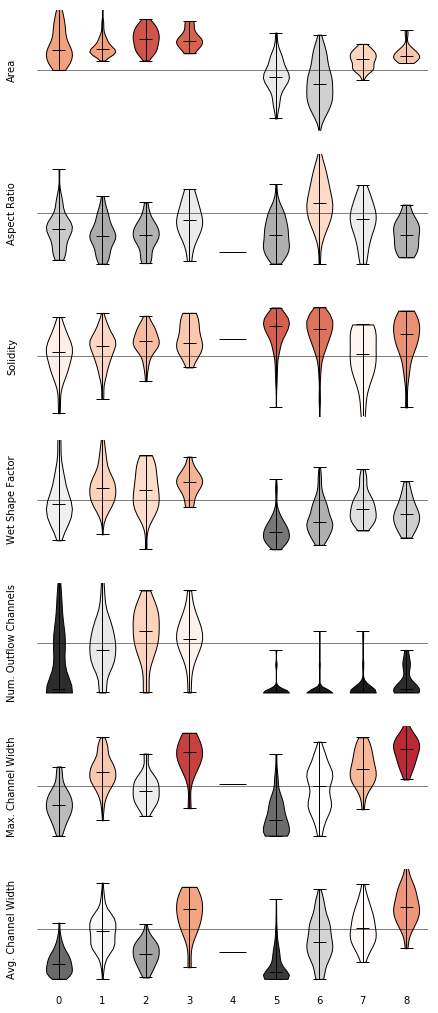

In [294]:
%matplotlib inline



data = pd.DataFrame()

for col in classify_data2.columns:
    
    p1,p99 = np.percentile(classify_data2[col],[1,99])
    data[col] = (classify_data2[col] - p1) / (p99 - p1)
    
data['class'] = new_classes2_all['0.3']



cmap = plt.cm.RdGy_r
norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)

# class_range = [3,11,14,0,4,13,7,9,12,6,16,15,1,18,2,8,5,10,17,]

class_range = np.unique(data['class'])
# class_range = [15,4,12,14, 6,7,22,10,20,16,23,1,8,24,2,0,3,21,5,9,11,13,17,18,19]
# class_range[:9] = [7,3,0,9,5,2,1,6,10]

sort = np.argsort(class_range)
line_range = np.arange(-0.5, data['class'].max() + 1, 0.5)


cols = ['Area',  'Aspect Ratio', 'Solidity',
       'Wet Shape Factor',  
       'Num. Outflow Channels', 'Max. Channel Width',
       'Avg. Channel Width']

# cols = classify_data2.columns

fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(7, 18))

vals_all = []
for nn,col in enumerate(cols):

    
    vals = [list(data.loc[data['class'] == i, col]- 0.5) for i in class_range]
    vals_med = [np.median(i) for i in vals]
    
    vals_all.append(vals_med)

    parts = axes[nn].violinplot(vals, np.unique(data['class']), points=20, widths=0.6,
                          showmeans=False, showextrema=True, showmedians=True,);

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)
    
    axes[nn].axhline(0, color='black', lw = 0.5)
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_ylim(-0.6,0.6)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    axes[nn].set_xticks(np.unique(data['class']))
#     axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis('off');
    axes[nn].spines['top'].set_visible(False)
    axes[nn].spines['right'].set_visible(False)
    axes[nn].spines['bottom'].set_visible(False)
    axes[nn].spines['left'].set_visible(False)

    h = axes[nn].set_ylabel(col, labelpad = 20)
    h.set_rotation(90)
    axes[nn].set_xlim(-0.5,8.5);#data['class'].max() + 0.5)

axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
axes[nn].set_xticks(np.unique(data['class']))
axes[nn].set_xticklabels(class_range);

# axes[0].set_title('GeoSOM 8x8, Kmeans K = 25')
axes[nn].set_xlim(-0.5,8.5);#data['class'].max() + 0.5)
plt.savefig('../pubs/violin_new_classes.png')



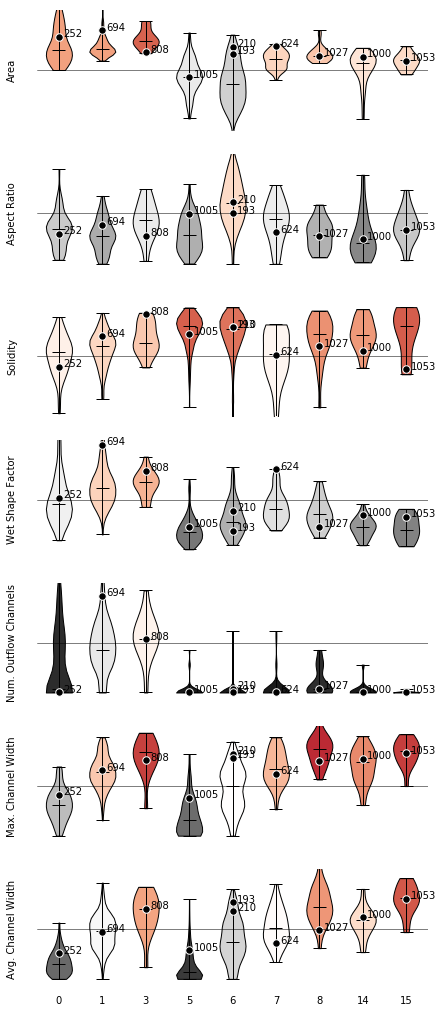

In [296]:
'''
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The final classification scheme uses
threshold = 0.8
distance = 0.3

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

r = 0.3

data['class'] = new_classes2_all[str(r)]


islands_of_interest = [252, 624, 694, 808, 1027, 1005, 1000, 1053, 210, 193]

ioi_classes_all = [data.loc[i,'class'] for i in islands_of_interest]
ioi_classes = np.unique(ioi_classes_all)

fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(7, 18))

vals_all = []

for nn,col in enumerate(cols):


    vals = [list(data.loc[data['class'] == i, col]- 0.5) for i in ioi_classes]
    vals_med = [np.median(i) for i in vals]

    vals_all.append(vals_med)

    parts = axes[nn].violinplot(vals, range(len(ioi_classes)), points=20, widths=0.6,
                          showmeans=False, showextrema=True, showmedians=True,);

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)


    for ioi_n, ioi in enumerate(islands_of_interest):

        xloc = np.where(ioi_classes == ioi_classes_all[ioi_n])[0][0]
        ioi_val = data.loc[ioi,col] - 0.5

        axes[nn].plot(xloc, ioi_val, '.', markeredgecolor = 'w', markerfacecolor = 'k' , markersize = 15)
        axes[nn].text(xloc+0.1, ioi_val, str(ioi))

    axes[nn].axhline(0, color='black', lw = 0.5)
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_ylim(-0.6,0.6)
    axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    axes[nn].set_xticks(np.unique(data['class']))
#     axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis('off');
    axes[nn].spines['top'].set_visible(False)
    axes[nn].spines['right'].set_visible(False)
    axes[nn].spines['bottom'].set_visible(False)
    axes[nn].spines['left'].set_visible(False)

    h = axes[nn].set_ylabel(col, labelpad = 20)
    h.set_rotation(90)
    axes[nn].set_xlim(-0.5,len(ioi_classes) - 0.5);#data['class'].max() + 0.5)

axes[nn].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
axes[nn].set_xticks(range(len(ioi_classes)))
axes[nn].set_xticklabels(ioi_classes);

plt.savefig('../pubs/violin_islands_of_interest.png')

In [298]:
pd.to_pickle(data, '../pubs/FINAL_CLASSIFICATION_DATA.p')

In [299]:

field['class'] = new_classes2_all['0.3']

field_type = {}
for k in field.keys():
    field_type[k] = ogr.OFTReal

create_shapefile_from_shapely_multi(islands,
                                    '../pubs/FINAL_CLASSES.shp',
                                    fields = field,
                                    field_type = field_type)